In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# import Path
import torch
import torch.nn.functional as F
import uproot
import yaml
from numpy.lib.recfunctions import structured_to_unstructured as s2u
from tqdm import tqdm

In [3]:
from hepattn.experiments.clic.pflow_data import CLICDataset

In [4]:
with open("/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_FullDiceFocFix_bf16_mixed_4gpu_20250628-T205247/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

with open(config["data"]["scale_dict_path"]) as f:
    scale_dict = yaml.load(f, Loader=yaml.SafeLoader)

In [5]:
ds = CLICDataset(
    filepath=config["data"]["test_path"],
    inputs={},
    targets={"particle": ["e", "pt", "eta", "sinphi", "cosphi"]},
    scale_dict_path=config["data"]["scale_dict_path"],
    num_events=1000,
)

Loading CLIC dataset from /share/gpu1/syw24/dmitrii_clic/test_clic_fix.root with 1000 samples
Is inference: False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 2055.10it/s]

Removing 19 events with too many nodes or particles
19 events with too many nodes
1 events with too many particles
Removing 0 events with mismatching track_particle_idx


Loading aux var particle_track_idx
Loading aux var track_particle_idx
Loading aux var topo2particle_topo_idx
Loading aux var topo2particle_particle_idx
Loading aux var topo2particle_energy
Number of events after filtering: 981


In [6]:
# eval_filepath = "../logs/CLIC_Pflow_Full_20250607-T234846/ckpts/epoch=082-val_loss=5.71306__test.h5"
eval_filepath = "/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_FullDiceFocFix_bf16_mixed_4gpu_20250628-T205247/ckpts/epoch=163-val_loss=1.41597__test.h5"

In [7]:
from scipy.optimize import linear_sum_assignment


def match_incidence_bool(input, target):
    input, target = torch.from_numpy(input).float(), torch.from_numpy(target).float()
    pos = F.binary_cross_entropy_with_logits(input, torch.ones_like(input), reduction="none")
    neg = F.binary_cross_entropy_with_logits(input, torch.zeros_like(input), reduction="none")
    pdist = torch.einsum("bnc,bmc->bnm", pos, target) + torch.einsum("bnc,bmc->bnm", neg, (1 - target))
    pdist = pdist.transpose(1, 2).numpy()
    assgn_indices = np.zeros((pdist.shape[0], pdist.shape[1]), dtype=int)
    for i, p in enumerate(pdist):
        _, col_ind = linear_sum_assignment(p)
        assgn_indices[i] = col_ind
    return assgn_indices

In [8]:
def match_incidence(input, target):
    assgn_indices = np.zeros((input.shape[0], input.shape[1]), dtype=int)
    input, target = torch.from_numpy(input).float(), torch.from_numpy(target).float()
    for i in tqdm(range(input.shape[0])):
        loss = -target[i, None, :] * torch.log(input[i, :, None] + 1e-8)
        loss = loss.mean(dim=-1).transpose(0, 1)
        _, col_ind = linear_sum_assignment(loss.numpy())
        assgn_indices[i] = col_ind
    return assgn_indices

In [9]:
def load_file(filepath, return_dict=False):
    with h5py.File(filepath, "r") as f:
        truth_incidence_bool = f["object_masks"]["truth_masks"][:]
        pflow_incidence_bool = f["object_masks"]["mask_logits"][:]

        if "incidence" in f:
            truth_incidence = f["incidence"]["truth_incidence"][:]
            pflow_incidence = f["incidence"]["pred_incidence"][:]
            # assgn_indices = match_incidence(pflow_incidence, truth_incidence)
            assgn_indices = np.zeros((pflow_incidence.shape[0], pflow_incidence.shape[1]), dtype=int)
            for i in tqdm(range(pflow_incidence.shape[0])):
                assgn_indices[i] = np.arange(pflow_incidence.shape[1])
        else:
            truth_incidence = np.zeros_like(truth_incidence_bool)
            pflow_incidence = np.zeros_like(pflow_incidence_bool)
            assgn_indices = match_incidence_bool(pflow_incidence_bool, truth_incidence_bool)
        first_idxs = np.arange(len(truth_incidence_bool))[:, None]

        pflow_incidence = pflow_incidence[first_idxs, assgn_indices, :]

        pflow_incidence_bool = pflow_incidence_bool[first_idxs, assgn_indices, :]

        truth_class = f["object_class"]["object_class"][:]
        pflow_class = f["object_class"]["pflow_class"][:]

        truth_vars = [f"truth_{el}" for el in ["e", "pt", "eta", "sinphi", "cosphi"]]
        pflow_vars = [f"pred_{el}" for el in ["e", "pt", "eta", "sinphi", "cosphi"]]
        proxy_vars = [f"proxy_{el}" for el in ["e", "pt", "eta", "sinphi", "cosphi"]]
        truth_data = s2u(f["regression"].fields(truth_vars)[:])
        pflow_data = s2u(f["regression"].fields(pflow_vars)[:])[first_idxs, assgn_indices, :]
        proxy_data = s2u(f["regression"].fields(proxy_vars)[:])[first_idxs, assgn_indices, :]

        pflow_ptetaphi = np.stack(
            [
                pflow_data[..., 1],
                pflow_data[..., 2],
                np.arctan2(pflow_data[..., 3], pflow_data[..., 4]),
            ],
            axis=-1,
        )
        truth_ptetaphi = np.stack(
            [
                truth_data[..., 1],
                truth_data[..., 2],
                np.arctan2(truth_data[..., 3], truth_data[..., 4]),
            ],
            axis=-1,
        )
        proxy_ptetaphi = np.stack(
            [
                proxy_data[..., 1],
                proxy_data[..., 2],
                np.arctan2(proxy_data[..., 3], proxy_data[..., 4]),
            ],
            axis=-1,
        )

        if "Bin" in filepath:
            pflow_indicator = pflow_class < 1
            truth_indicator = truth_class < 1
        else:
            pflow_indicator = pflow_class < 5
            # pflow_indicator = truth_class < 5
            truth_indicator = truth_class < 5

        neutral_mask = (pflow_class < 5) & (pflow_class > 2)
        pflow_ptetaphi[neutral_mask][..., 0] = pflow_data[neutral_mask][..., 0] / np.cosh(pflow_ptetaphi[neutral_mask][..., 1])
        proxy_ptetaphi[neutral_mask][..., 0] = proxy_data[neutral_mask][..., 0] / np.cosh(proxy_ptetaphi[neutral_mask][..., 1])
        if return_dict:
            return {
                "pflow_incidence": pflow_incidence,
                "truth_incidence": truth_incidence,
                "pflow_class": pflow_class,
                "truth_class": truth_class,
                "pflow_data": pflow_data,
                "truth_data": truth_data,
                "proxy_data": proxy_data,
                "pflow_ptetaphi": pflow_ptetaphi,
                "truth_ptetaphi": truth_ptetaphi,
                "proxy_ptetaphi": proxy_ptetaphi,
                "pflow_indicator": pflow_indicator,
                "truth_indicator": truth_indicator,
            }

        return (
            pflow_incidence,
            truth_incidence,
            pflow_incidence_bool,
            truth_incidence_bool,
            pflow_class,
            truth_class,
            pflow_data,
            truth_data,
            proxy_data,
            pflow_ptetaphi,
            truth_ptetaphi,
            proxy_ptetaphi,
            pflow_indicator,
            truth_indicator,
        )

In [10]:
(
    pflow_incidence,
    truth_incidence,
    pflow_incidence_bool,
    truth_incidence_bool,
    pflow_class,
    truth_class,
    pflow_data,
    truth_data,
    proxy_data,
    pflow_ptetaphi,
    truth_ptetaphi,
    proxy_ptetaphi,
    pflow_indicator,
    truth_indicator,
) = load_file(eval_filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 595190.75it/s]


In [11]:
def sigmoid(x, alpha=1):
    x = x * alpha
    return 1 / (1 + np.exp(-x))

/tmp/ipykernel_37631/463194794.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Number of tracks: 24


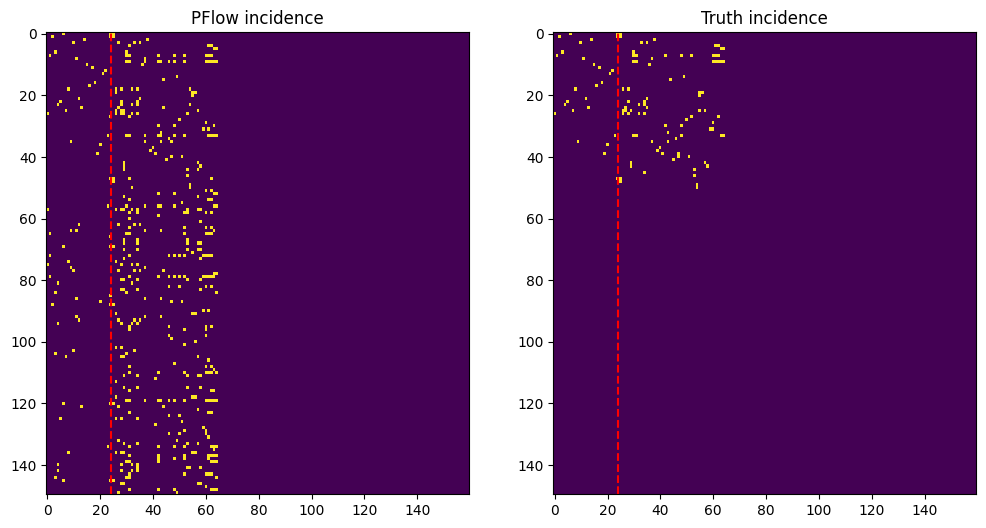

In [12]:
idx = 10
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
node_mask = ds[idx][1]["node_valid"]
n_tracks = ds.n_tracks[idx]
ax[0].imshow(
    ((sigmoid(pflow_incidence_bool[idx]) > 0.1) * node_mask.unsqueeze(0).numpy()),
    interpolation="nearest",
    aspect="auto",
)
ax[0].axvline(n_tracks, color="red", linestyle="--")
ax[0].set_title("PFlow incidence")
ax[1].imshow(
    truth_incidence_bool[idx],
    interpolation="nearest",
    aspect="auto",
)
ax[1].axvline(n_tracks, color="red", linestyle="--")
ax[1].set_title("Truth incidence")
print("Number of tracks:", n_tracks)
plt.show()

/tmp/ipykernel_37631/463194794.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


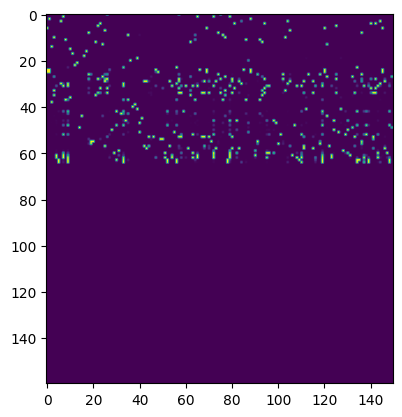

In [13]:
plt.imshow(sigmoid(pflow_incidence_bool[idx]).T)

Number of tracks: 17


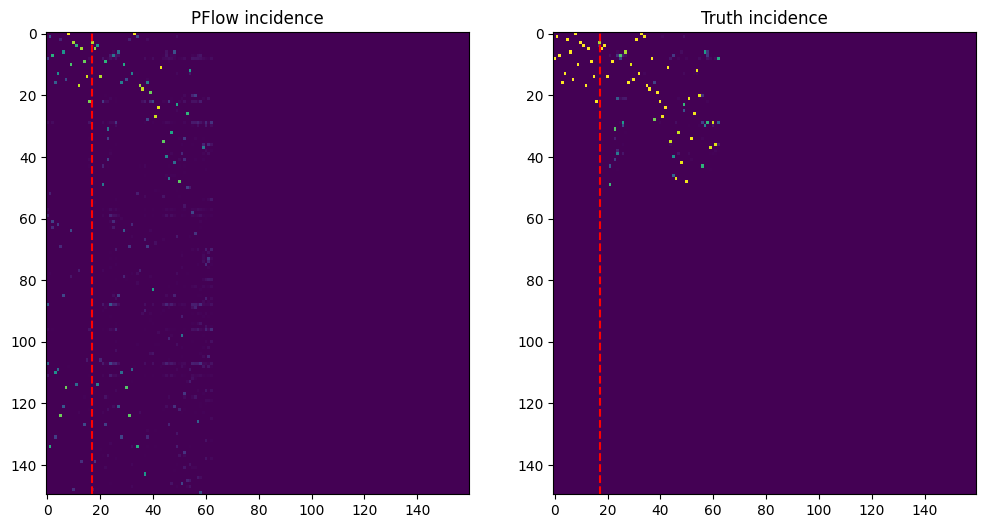

In [14]:
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
node_mask = ds[idx][1]["node_valid"]
n_tracks = ds.n_tracks[idx]
ax[0].imshow(
    (pflow_incidence[idx] * node_mask.unsqueeze(0).numpy()),
    interpolation="nearest",
    aspect="auto",
)
ax[0].axvline(n_tracks, color="red", linestyle="--")
ax[0].set_title("PFlow incidence")
ax[1].imshow(
    truth_incidence[idx],
    interpolation="nearest",
    aspect="auto",
)
ax[1].axvline(n_tracks, color="red", linestyle="--")
ax[1].set_title("Truth incidence")
print("Number of tracks:", n_tracks)
plt.show()

In [15]:
pflow_class[0]

array([0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 4, 4, 0, 0, 5, 0, 0, 4, 4, 5, 5,
       0, 4, 4, 5, 4, 4, 5, 5, 5, 4, 4, 5, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5,
       5, 5, 5, 3, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 0, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0,
       5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3])

In [16]:
pflow_class[0]

array([0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 4, 4, 0, 0, 5, 0, 0, 4, 4, 5, 5,
       0, 4, 4, 5, 4, 4, 5, 5, 5, 4, 4, 5, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5,
       5, 5, 5, 3, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 0, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0,
       5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 3])

In [17]:
proxy_data[0, :10, 2]

array([-0.64746094, -0.57714844, -0.984375  , -1.3183594 , -1.5117188 ,
       -1.5       , -1.7460938 , -1.9804688 , -2.0273438 , -0.6591797 ],
      dtype=float32)

In [18]:
proxy_ptetaphi[0, :10, 1]

array([-0.64746094, -0.57714844, -0.984375  , -1.3183594 , -1.5117188 ,
       -1.5       , -1.7460938 , -1.9804688 , -2.0273438 , -0.6591797 ],
      dtype=float32)

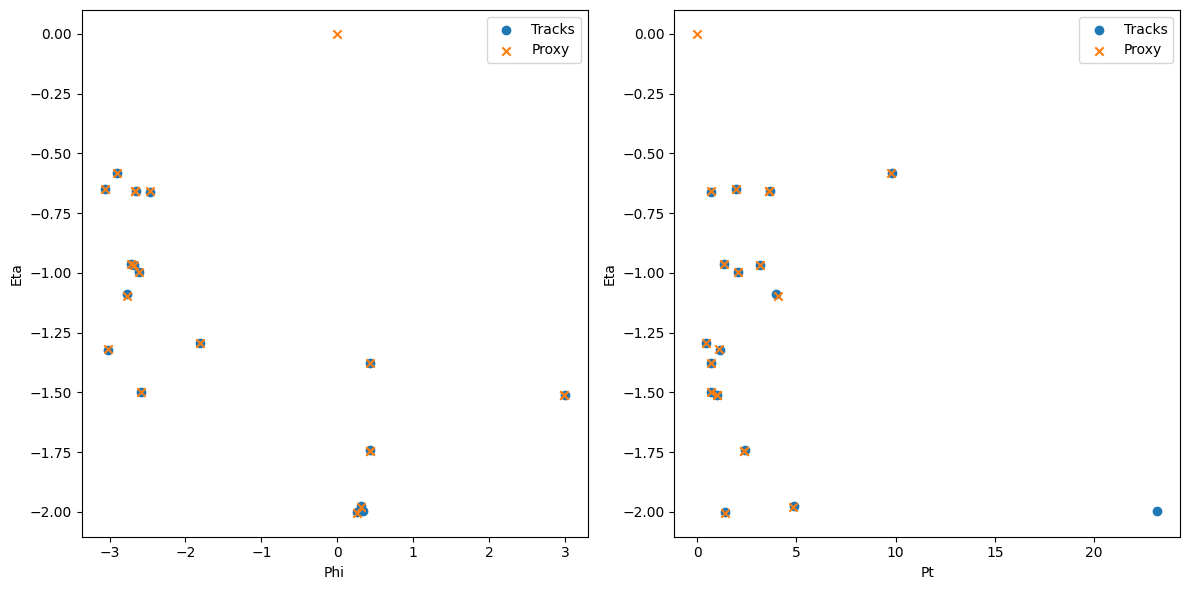

In [19]:
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
inputs = ds[idx][0]

ax[0].scatter(
    inputs["node_phi"][inputs["node_is_track"] > 0],
    inputs["node_eta"][inputs["node_is_track"] > 0],
    marker="o",
    label="Tracks",
)
ax[0].scatter(
    proxy_ptetaphi[idx, :, 2][pflow_class[idx] < 3],
    proxy_ptetaphi[idx, :, 1][pflow_class[idx] < 3],
    marker="x",
    label="Proxy",
)
ax[1].scatter(
    inputs["node_pt"][inputs["node_is_track"] > 0],
    inputs["node_eta"][inputs["node_is_track"] > 0],
    marker="o",
    label="Tracks",
)
ax[1].scatter(
    proxy_ptetaphi[idx, :, 0][pflow_class[idx] < 3],
    proxy_ptetaphi[idx, :, 1][pflow_class[idx] < 3],
    marker="x",
    label="Proxy",
)
ax[0].set_xlabel("Phi")
ax[0].set_ylabel("Eta")
ax[1].set_xlabel("Pt")
ax[1].set_ylabel("Eta")
ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.show()

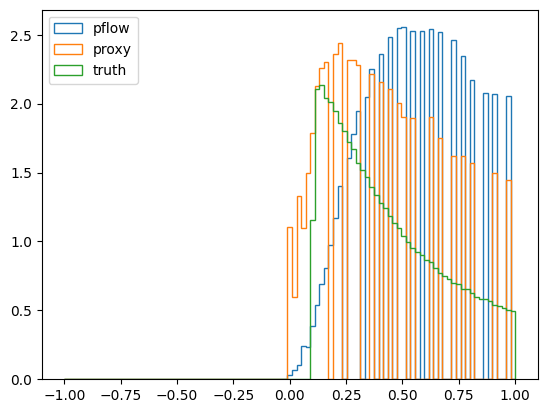

In [20]:
plt.hist(pflow_data[..., 1][pflow_indicator], bins=np.linspace(-1, 1, 100), histtype="step", label="pflow", density=True)
plt.hist(proxy_data[..., 1][pflow_indicator], bins=np.linspace(-1, 1, 100), histtype="step", label="proxy", density=True)
plt.hist(truth_data[..., 1][truth_indicator], bins=np.linspace(-1, 1, 100), histtype="step", label="truth", density=True)
plt.legend()

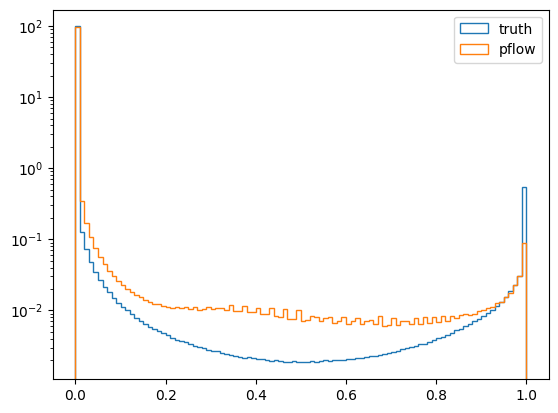

In [21]:
plt.hist(truth_incidence[truth_indicator].flatten(), bins=100, histtype="step", label="truth", density=True)
plt.hist(pflow_incidence[pflow_indicator].flatten(), bins=100, histtype="step", label="pflow", density=True)
plt.yscale("log")
plt.legend()

In [22]:
n_truth = ds.n_particles[0]
particle_data = torch.stack(
    [
        ds.full_data_array["particle_e"][:n_truth],
        ds.full_data_array["particle_pt"][:n_truth],
        ds.full_data_array["particle_eta"][:n_truth],
        torch.sin(ds.full_data_array["particle_phi"][:n_truth]),
        torch.cos(ds.full_data_array["particle_phi"][:n_truth]),
    ],
    -1,
)
particle_class = ds.particle_class[:n_truth]

In [23]:
node_raw_features = ds.load_event(0)["node_raw_features"]

In [24]:
inputs = {
    "e": node_raw_features["raw_e"].unsqueeze(0),
    "pt": node_raw_features["raw_pt"].unsqueeze(0),
    "eta": node_raw_features["raw_eta"].unsqueeze(0),
    "sinphi": node_raw_features["sinphi"].unsqueeze(0),
    "cosphi": node_raw_features["cosphi"].unsqueeze(0),
    "is_track": node_raw_features["is_track"].unsqueeze(0),
}

In [25]:
proxy_feats = torch.cat(
    [
        node_raw_features["raw_e"].unsqueeze(-1),
        node_raw_features["raw_pt"].unsqueeze(-1),
        node_raw_features["raw_eta"].unsqueeze(-1),
        node_raw_features["sinphi"].unsqueeze(-1),
        node_raw_features["cosphi"].unsqueeze(-1),
    ],
    axis=-1,
)

In [26]:
from hepattn.utils.masks import topk_attn


def get_proxy_feats(incidence: torch.Tensor, inputs: dict, class_probs: torch.Tensor | None = None):
    proxy_feats = torch.cat(
        [
            inputs["e"].unsqueeze(-1),
            inputs["pt"].unsqueeze(-1),
            inputs["eta"].unsqueeze(-1),
            inputs["sinphi"].unsqueeze(-1),
            inputs["cosphi"].unsqueeze(-1),
        ],
        axis=-1,
    )
    charged_inc = incidence * inputs["is_track"].unsqueeze(1)
    # Use the most weighted track as proxy for charged particles
    charged_inc_top2 = (topk_attn(charged_inc, 2, dim=-2) & (charged_inc > 0)).float()
    charged_inc_max = charged_inc.max(-2, keepdim=True)[0]
    charged_inc_new = (charged_inc == charged_inc_max) & (charged_inc > 0)
    charged_inc_new = charged_inc.float()
    zero_track_mask = charged_inc_new.sum(-1, keepdim=True) == 0
    charged_inc = torch.where(zero_track_mask, charged_inc_top2, charged_inc_new)

    # Split charged and neutral
    is_charged = class_probs.argmax(-1) < 3
    proxy_feats_charged = torch.bmm(charged_inc, proxy_feats)
    proxy_feats_charged[..., 0] = proxy_feats_charged[..., 1] * torch.cosh(proxy_feats_charged[..., 2])
    proxy_feats_charged = proxy_feats_charged * is_charged.unsqueeze(-1)

    inc_e_weighted = incidence.detach() * proxy_feats[..., 0].unsqueeze(1)
    inc_e_weighted = inc_e_weighted * (1 - inputs["is_track"]).unsqueeze(1)
    inc = inc_e_weighted / (inc_e_weighted.sum(dim=-1, keepdim=True) + 1e-6)

    proxy_feats_neutral = torch.einsum("bnf,bpn->bpf", proxy_feats, inc)
    print(proxy_feats_neutral[0, :26, 2])
    proxy_feats_neutral[..., 0] = inc_e_weighted.sum(dim=-1)
    proxy_feats_neutral[..., 1] = proxy_feats_neutral[..., 0] / torch.cosh(proxy_feats_neutral[..., 2])
    # print(proxy_feats_neutral)
    proxy_feats_neutral = proxy_feats_neutral * (~is_charged).unsqueeze(-1)
    proxy_feats = proxy_feats_charged + proxy_feats_neutral

    return proxy_feats

In [27]:
truth_class_probs = torch.nn.functional.one_hot(torch.from_numpy(truth_class[0]).unsqueeze(0), num_classes=6).float()
pflow_class_probs = torch.nn.functional.one_hot(torch.from_numpy(pflow_class[0]).unsqueeze(0), num_classes=6).float()
truth_incidence_torch = torch.from_numpy(truth_incidence)[0].unsqueeze(0)
pflow_incidence_torch = torch.from_numpy(pflow_incidence)[0].unsqueeze(0)

In [28]:
proxy_feats_truth = get_proxy_feats(truth_incidence_torch, inputs, truth_class_probs)
proxy_feats_pflow = get_proxy_feats(pflow_incidence_torch, inputs, pflow_class_probs)

tensor([-0.6840, -0.5771, -0.9815, -1.4201, -1.5246, -1.6305, -1.8593, -1.9480,
        -1.9161, -2.7610, -1.0275, -0.3636, -0.7511, -0.6551, -2.0153, -1.0182,
        -1.0961, -1.6098, -2.1721, -1.7991, -2.4530, -1.9777, -2.0388, -0.6717,
        -0.6472, -0.6717])
tensor([-0.6862, -0.5787, -0.9843, -1.4201, -1.5417, -1.6334, -1.8179, -1.9443,
        -2.0255, -2.7510, -1.0287, -0.3637, -0.7495, -0.6622, -2.0156, -1.0187,
        -1.0981, -1.6099, -2.1718, -1.8006, -2.4192, -2.0118, -2.0970, -0.6716,
        -0.6472, -0.6670])


In [29]:
ch_inc = pflow_incidence_torch * inputs["is_track"].unsqueeze(1)

In [30]:
ch_inc_bool = torch.zeros_like(ch_inc)
# ch_inc_bool[:, :, torch.argmax(ch_inc, -1)[0]] = 1

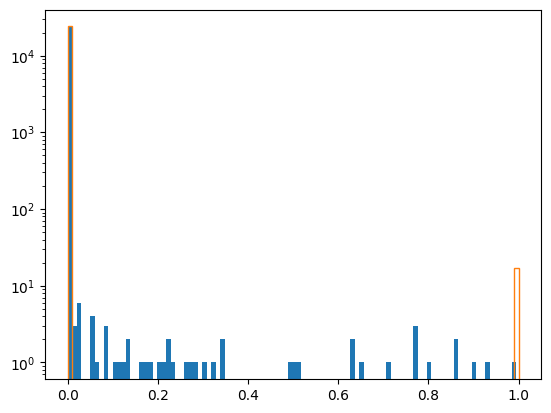

In [31]:
plt.hist((pflow_incidence_torch * inputs["is_track"].unsqueeze(1)).flatten(), bins=100)
plt.hist((truth_incidence_torch * inputs["is_track"].unsqueeze(1)).flatten(), bins=100, histtype="step")
plt.yscale("log")

In [32]:
proxy_feats_pflow_raw = get_proxy_feats(torch.from_numpy(pflow_incidence)[0].unsqueeze(0), inputs, class_probs=pflow_class_probs)

tensor([-0.6862, -0.5787, -0.9843, -1.4201, -1.5417, -1.6334, -1.8179, -1.9443,
        -2.0255, -2.7510, -1.0287, -0.3637, -0.7495, -0.6622, -2.0156, -1.0187,
        -1.0981, -1.6099, -2.1718, -1.8006, -2.4192, -2.0118, -2.0970, -0.6716,
        -0.6472, -0.6670])


In [33]:
proxy_feats_pflow_raw[0, :, 2].numpy()[pflow_class[0] < 3]

array([-0.6467629 , -1.1453689 , -0.9838894 , -1.2923958 , -0.8920109 ,
       -1.2534722 , -0.5079382 , -0.68626964, -0.32619527, -1.2057468 ,
       -0.33372337, -1.2432119 , -1.5943607 , -0.37287146, -0.22424029,
       -0.52622247, -0.7724208 , -0.47745118, -0.75015515, -0.3676069 ],
      dtype=float32)

In [34]:
proxy_data[0][..., 2][pflow_class[0] < 3]

array([-0.64746094, -1.3183594 , -1.5117188 , -1.5       , -1.7460938 ,
       -1.9804688 , -0.6591797 , -0.9609375 , -0.65625   , -1.2949219 ,
       -1.0957031 , -1.3769531 , -2.0039062 ,  0.        , -0.65625   ,
       -1.5117188 , -0.99609375, -1.7460938 , -0.9667969 , -0.5830078 ],
      dtype=float32)

In [35]:
truth_data[0][..., 2][truth_class[0] < 3]

array([-0.6494834 , -0.5808587 , -0.96826303, -1.3241332 , -1.5109148 ,
       -1.4975139 , -1.7423253 , -1.9765816 , -1.9953427 , -0.6618885 ,
       -0.9628264 , -0.65612423, -1.2884796 , -0.9975506 , -1.0903454 ,
       -1.3781928 , -1.9986014 ], dtype=float32)

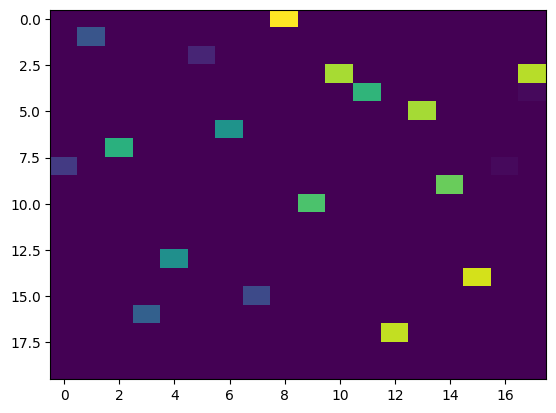

In [36]:
plt.imshow(pflow_incidence[0][:20, :18], interpolation="nearest", aspect="auto")

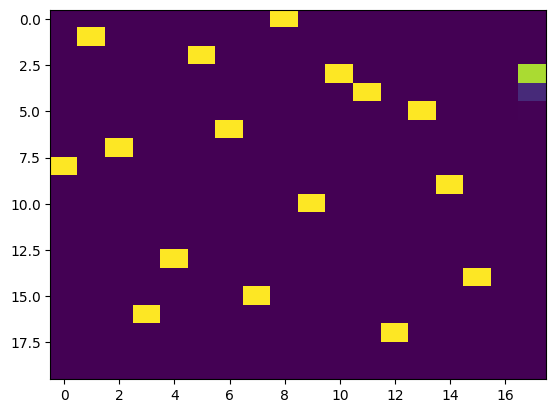

In [37]:
plt.imshow(truth_incidence[0][:20, :18], interpolation="nearest", aspect="auto")

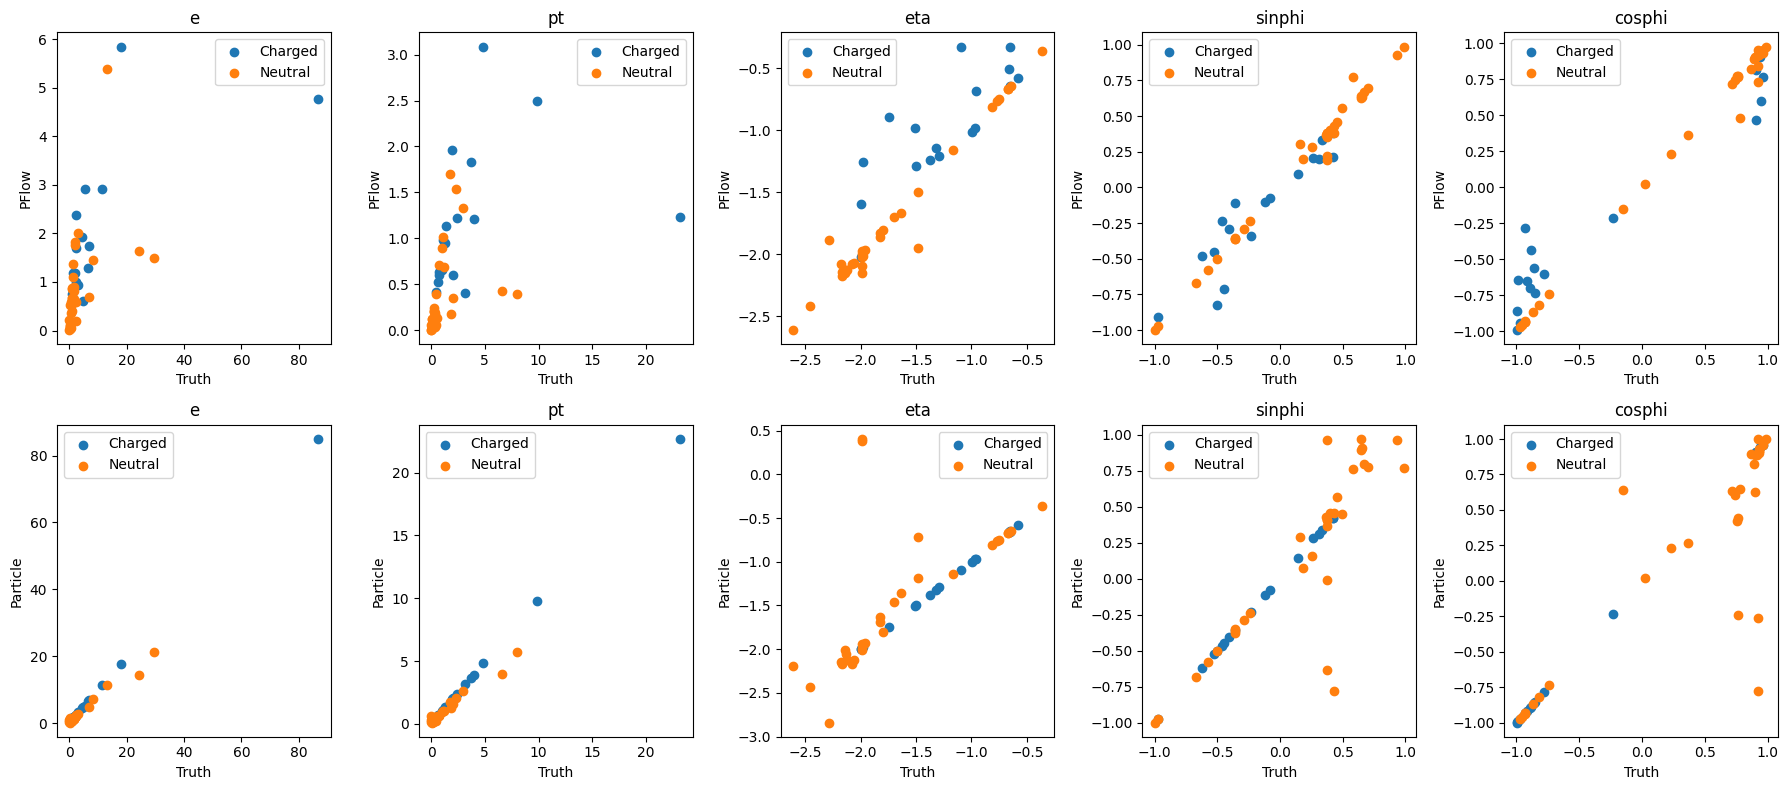

In [38]:
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
mask = truth_indicator[0]
labels = ["e", "pt", "eta", "sinphi", "cosphi"]
# truth_idx = torch.argsort(proxy_feats_truth[0, :, 2][mask])
# pflow_idx = torch.argsort(proxy_feats_pflow[0, :, 2][mask])
# particle_idx = torch.argsort(particle_data[:, 2])
class_labels_ = ["Charged", "Neutral"]
charge_masks_proxy = [truth_class[0] < 3, truth_class[0] > 2]
charge_masks_particle = [particle_class < 3, (particle_class > 2) & (particle_class < 5)]
for i in range(5):
    for j in range(2):
        ax[0][i].scatter(
            proxy_feats_truth[0, :, i][mask & charge_masks_proxy[j]],
            proxy_feats_pflow[0, :, i][mask & charge_masks_proxy[j]],
            label=class_labels_[j],
        )
        ax[1][i].scatter(
            proxy_feats_truth[0, :, i][mask & charge_masks_proxy[j]],
            particle_data[:, i][charge_masks_particle[j]],
            label=class_labels_[j],
        )
    ax[0][i].set_title(labels[i])
    ax[1][i].set_title(labels[i])
    ax[0][i].set_xlabel("Truth")
    ax[0][i].set_ylabel("PFlow")
    ax[1][i].set_xlabel("Truth")
    ax[1][i].set_ylabel("Particle")
    ax[0][i].legend()
    ax[1][i].legend()
fig.tight_layout()
plt.show()

In [39]:
inc_e_weighted = torch.from_numpy(pflow_incidence)[0].unsqueeze(0) * inputs["e"]

In [40]:
inc_e_weighted.sum(-1)[0][pflow_class[0] < 5]

tensor([ 1.7172,  2.0930,  0.8214,  1.1238,  4.1343, 14.8381,  0.1252,  0.6876,
         1.8173,  0.8939,  1.8762,  0.6943,  2.6071,  3.2713,  1.7659,  0.6665,
         2.0544,  1.1097,  0.8592,  2.0136,  1.3638,  0.8048,  0.6685,  0.5872,
         0.6577,  0.1171,  0.1015,  0.3970,  0.8709,  0.3704,  1.1314,  2.8652,
         0.0244,  0.8414,  1.4761,  0.6307,  2.8122,  4.0788,  4.8122,  8.5365,
         0.8722,  1.2971])

In [41]:
proxy_feats_truth[0, :, 0][pflow_class[0] < 5]

tensor([ 2.4035,  2.2844,  2.3916,  1.6449,  7.0276, 17.9207,  0.8458,  2.0079,
         1.8779,  1.5498,  4.5176,  0.8736,  6.5597,  1.4763,  1.9234,  0.8580,
         5.3764,  1.2526,  0.8983,  3.0336,  1.4648,  1.5174,  0.8592,  0.7114,
         1.6497,  0.1272,  0.2416,  0.9884,  1.1302,  0.6294,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])

In [42]:
# truth_mask = truth_indicator[0]
# pflow_mask = pflow_indicator[0]
truth_mask = truth_class[0] < 5  # & (truth_class[0] > 2)
pflow_mask = pflow_class[0] < 5  # & (pflow_class[0] > 2)

In [43]:
torch.sum(proxy_feats_truth[0, :, 2][truth_mask] > 2)

tensor(0)

In [44]:
pflow_incidence[0][0]

array([1.4969572e-11, 5.2696553e-10, 1.1433537e-16, 1.2966265e-12,
       1.1024003e-09, 7.3243890e-13, 1.9851449e-13, 2.5539987e-12,
       9.9547642e-01, 2.1499190e-08, 1.3718399e-04, 1.8007268e-10,
       3.1222733e-08, 3.2266666e-08, 1.4274223e-10, 5.9508098e-10,
       1.8248314e-11, 1.8248501e-03, 4.9267965e-06, 1.7915140e-06,
       2.3556817e-05, 1.4511384e-05, 1.3939047e-06, 4.0931560e-08,
       1.6910420e-06, 2.5850346e-08, 1.8463601e-06, 1.5033351e-08,
       7.4661550e-08, 5.2250602e-08, 8.1355322e-09, 7.2349614e-08,
       1.0311102e-06, 9.8961383e-01, 3.1517040e-06, 2.7726552e-05,
       2.3043549e-06, 3.0794483e-05, 4.4569071e-05, 6.0639336e-06,
       6.2236717e-07, 2.2340560e-06, 1.1750489e-06, 2.0309098e-04,
       1.8620689e-06, 3.4127026e-04, 7.2807845e-05, 1.3717424e-07,
       3.1557957e-07, 1.0113421e-06, 8.3343590e-09, 9.6455421e-10,
       8.4951193e-07, 1.6969425e-07, 1.2089680e-07, 6.6404273e-06,
       1.4200815e-06, 2.0100977e-05, 1.3987233e-06, 3.8120938e

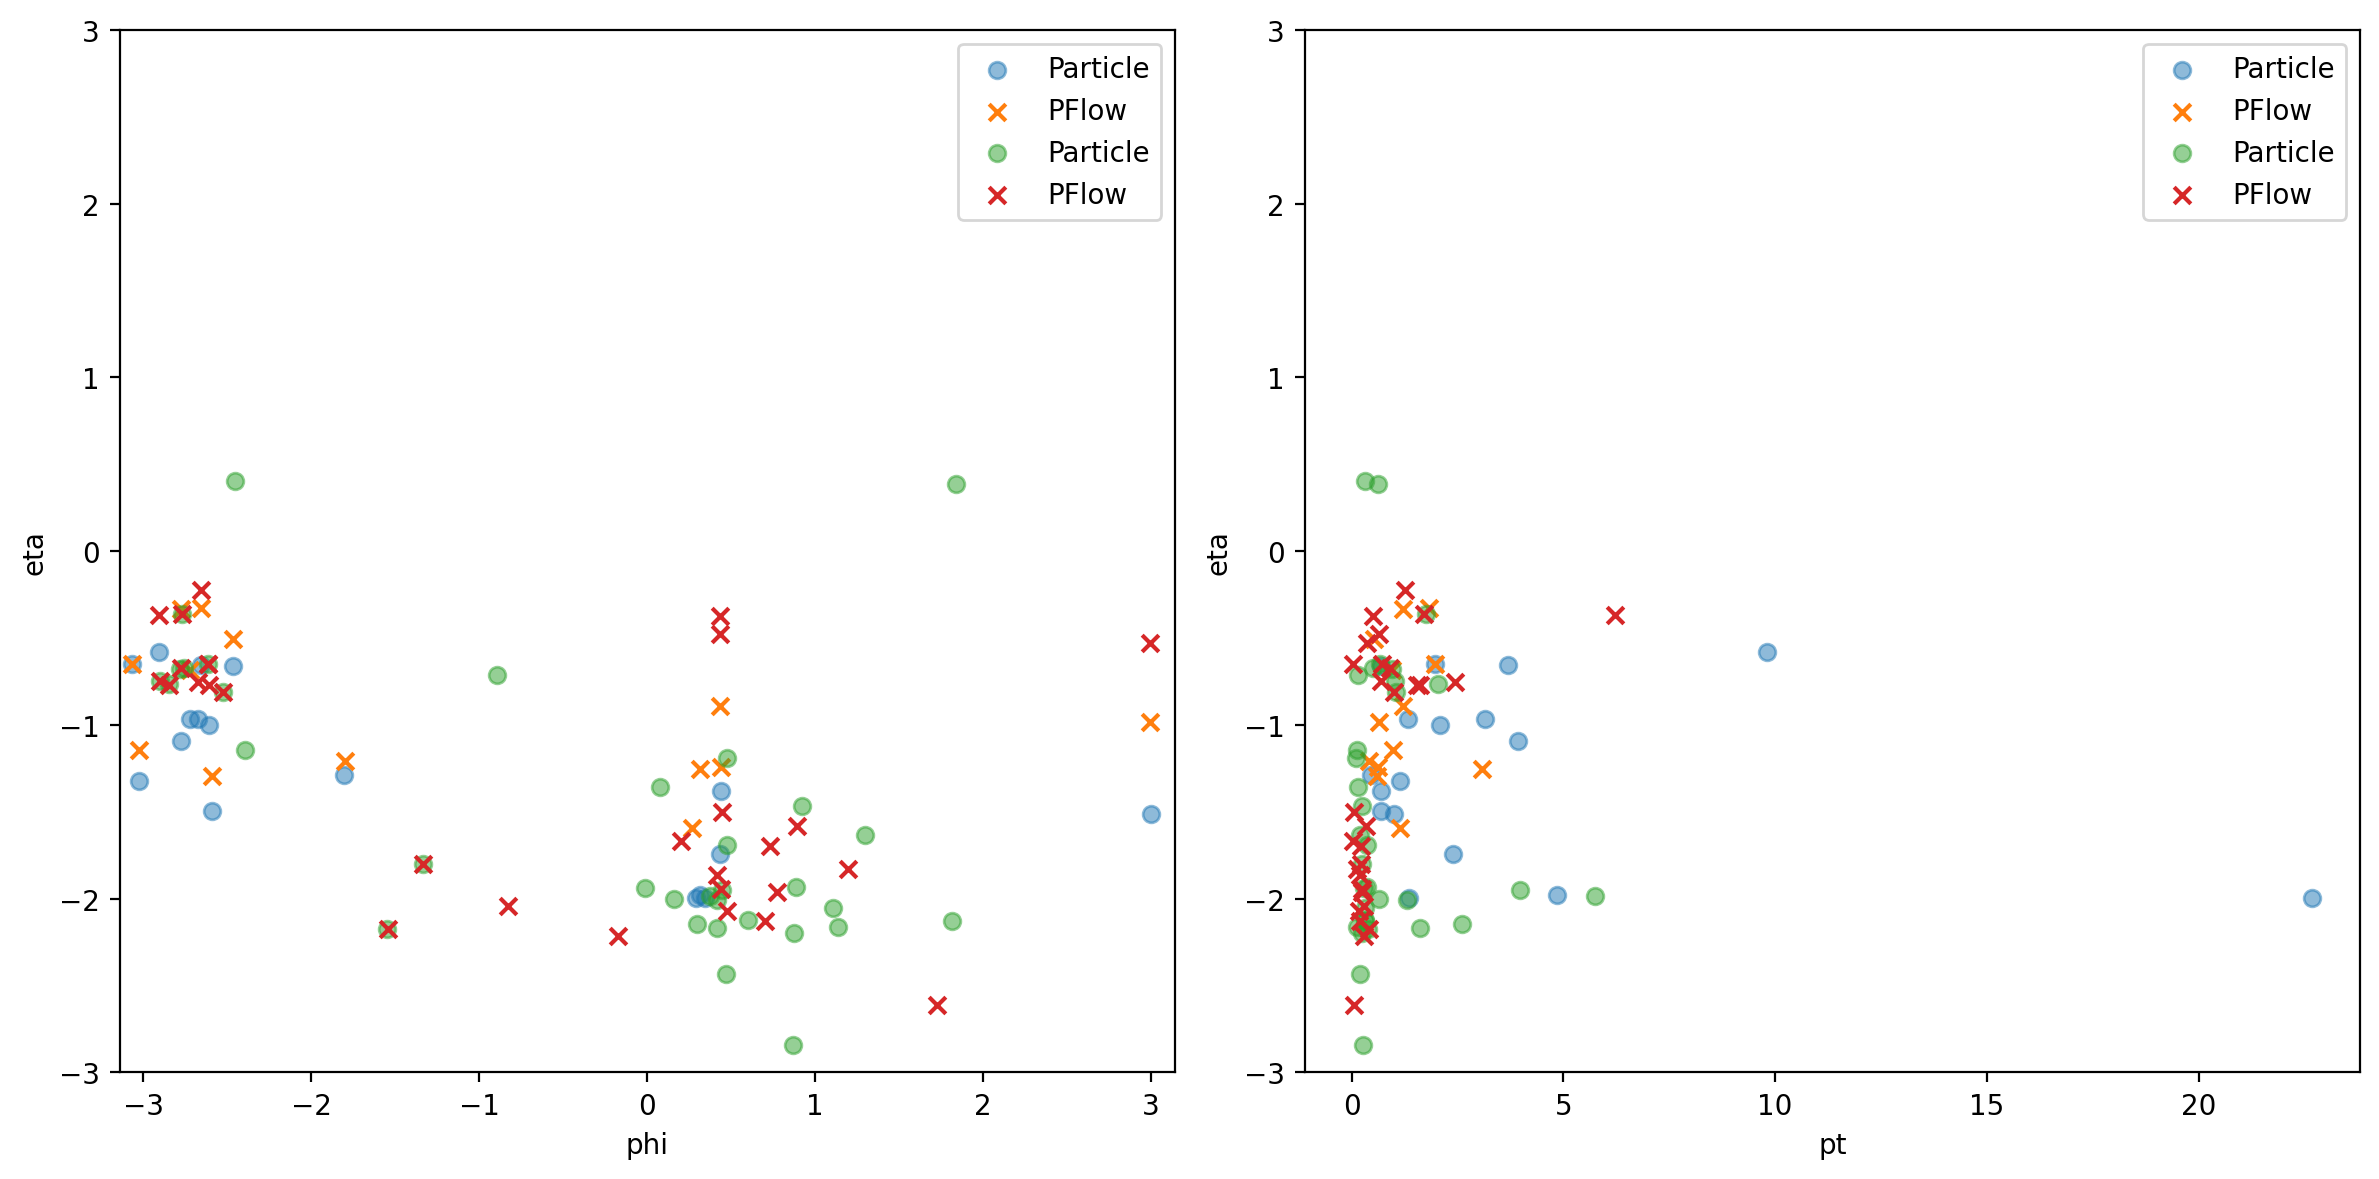

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
for i, (pr_charge_mask, tr_charge_mask) in enumerate(zip(charge_masks_proxy, charge_masks_particle, strict=False)):
    # ax[0].scatter(
    #     torch.atan2(proxy_feats_truth[0, :, 3], proxy_feats_truth[0, :, 4])[truth_mask & tr_charge_mask],
    #     proxy_feats_truth[0, :, 2][truth_mask & tr_charge_mask],
    #     label="Truth",
    #     marker="s",
    #     facecolors="none",
    #     color="g",
    # )
    ax[0].scatter(
        torch.arctan2(particle_data[:, 3], particle_data[:, 4])[tr_charge_mask], particle_data[:, 2][tr_charge_mask], label="Particle", alpha=0.5
    )
    ax[0].scatter(
        torch.atan2(proxy_feats_pflow[0, :, 3], proxy_feats_pflow[0, :, 4])[pflow_mask & pr_charge_mask],
        proxy_feats_pflow[0, :, 2][pflow_mask & pr_charge_mask],
        marker="x",
        label="PFlow",
    )
    ax[0].set_xlabel("phi")
    ax[0].set_ylabel("eta")
    ax[1].scatter(particle_data[:, 1][tr_charge_mask], particle_data[:, 2][tr_charge_mask], label="Particle", alpha=0.5)
    # ax[1].scatter(
    #     proxy_feats_truth[0, :, 1][truth_mask],
    #     proxy_feats_truth[0, :, 2][truth_mask],
    #     label="Truth",
    #     marker="s",
    #     facecolors="none",
    #     color="g",
    # )
    ax[1].scatter(
        proxy_feats_pflow[0, :, 1][pflow_mask & pr_charge_mask],
        proxy_feats_pflow[0, :, 2][pflow_mask & pr_charge_mask],
        marker="x",
        label="PFlow",
    )
ax[1].set_xlabel("pt")
ax[1].set_ylabel("eta")
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(-np.pi, np.pi)
ax[0].set_ylim(-3, 3)
ax[1].set_ylim(-3, 3)
fig.tight_layout()
plt.show()

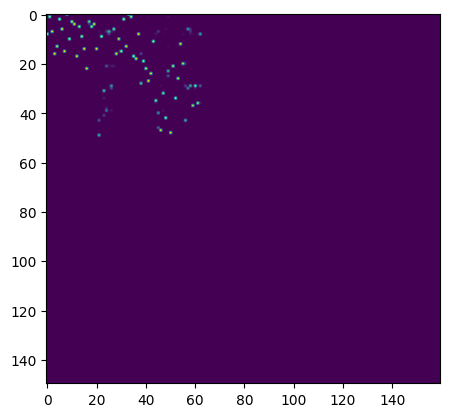

In [46]:
plt.imshow(truth_incidence[0])

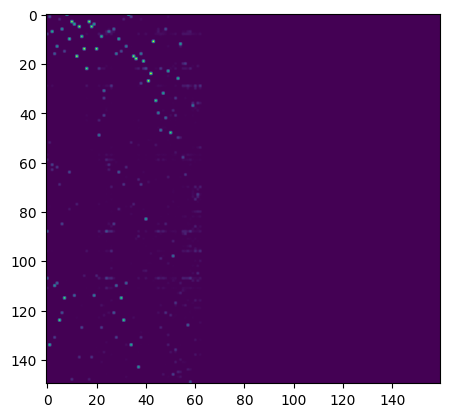

In [47]:
plt.imshow(pflow_incidence[0])

In [48]:
def calc_n_particles(pflow_indicator, truth_indicator, ind_threshold=0.5):
    n_pflow = []
    n_truth = []
    n_proxy = []
    for i in range(len(pflow_ptetaphi)):
        n_pflow.append((pflow_indicator[i] > ind_threshold).sum())
        n_proxy.append((pflow_indicator[i] > ind_threshold).sum())
        n_truth.append((truth_indicator[i] > ind_threshold).sum())
    return n_pflow, n_truth, n_proxy

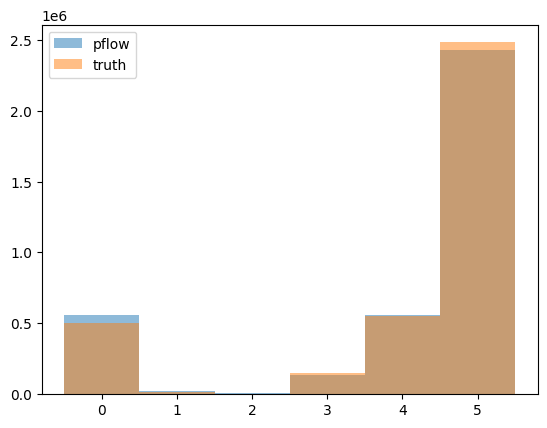

In [49]:
plt.hist(pflow_class.flatten(), bins=np.arange(-0.5, 6.5), alpha=0.5, label="pflow")
plt.hist(truth_class.flatten(), bins=np.arange(-0.5, 6.5), alpha=0.5, label="truth")
# plt.yscale('log')
plt.legend()
plt.show()

In [50]:
n_pflow, n_truth, n_proxy = calc_n_particles(pflow_indicator, truth_indicator, ind_threshold=0.5)

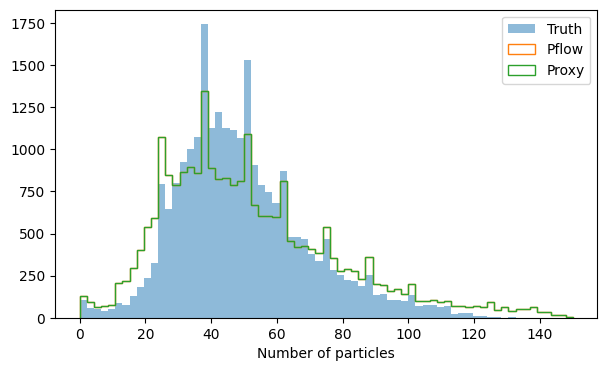

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

npart_bins = np.linspace(0, 150, 70)
ax.hist(
    n_truth,
    bins=npart_bins,
    histtype="stepfilled",
    alpha=0.5,
    label="Truth",
)
ax.hist(
    n_pflow,
    bins=npart_bins,
    histtype="step",
    label="Pflow",
)
ax.hist(
    n_proxy,
    bins=npart_bins,
    histtype="step",
    label="Proxy",
)
ax.legend()
ax.set_xlabel("Number of particles")
plt.show()

In [52]:
pflow_indicator = (pflow_class < 5) & (np.abs(pflow_ptetaphi[..., 1]) < 3)
# pflow_indicator = (np.abs(pflow_ptetaphi[..., 1]) < 3) & (pflow_indicator_prob > 0.7)

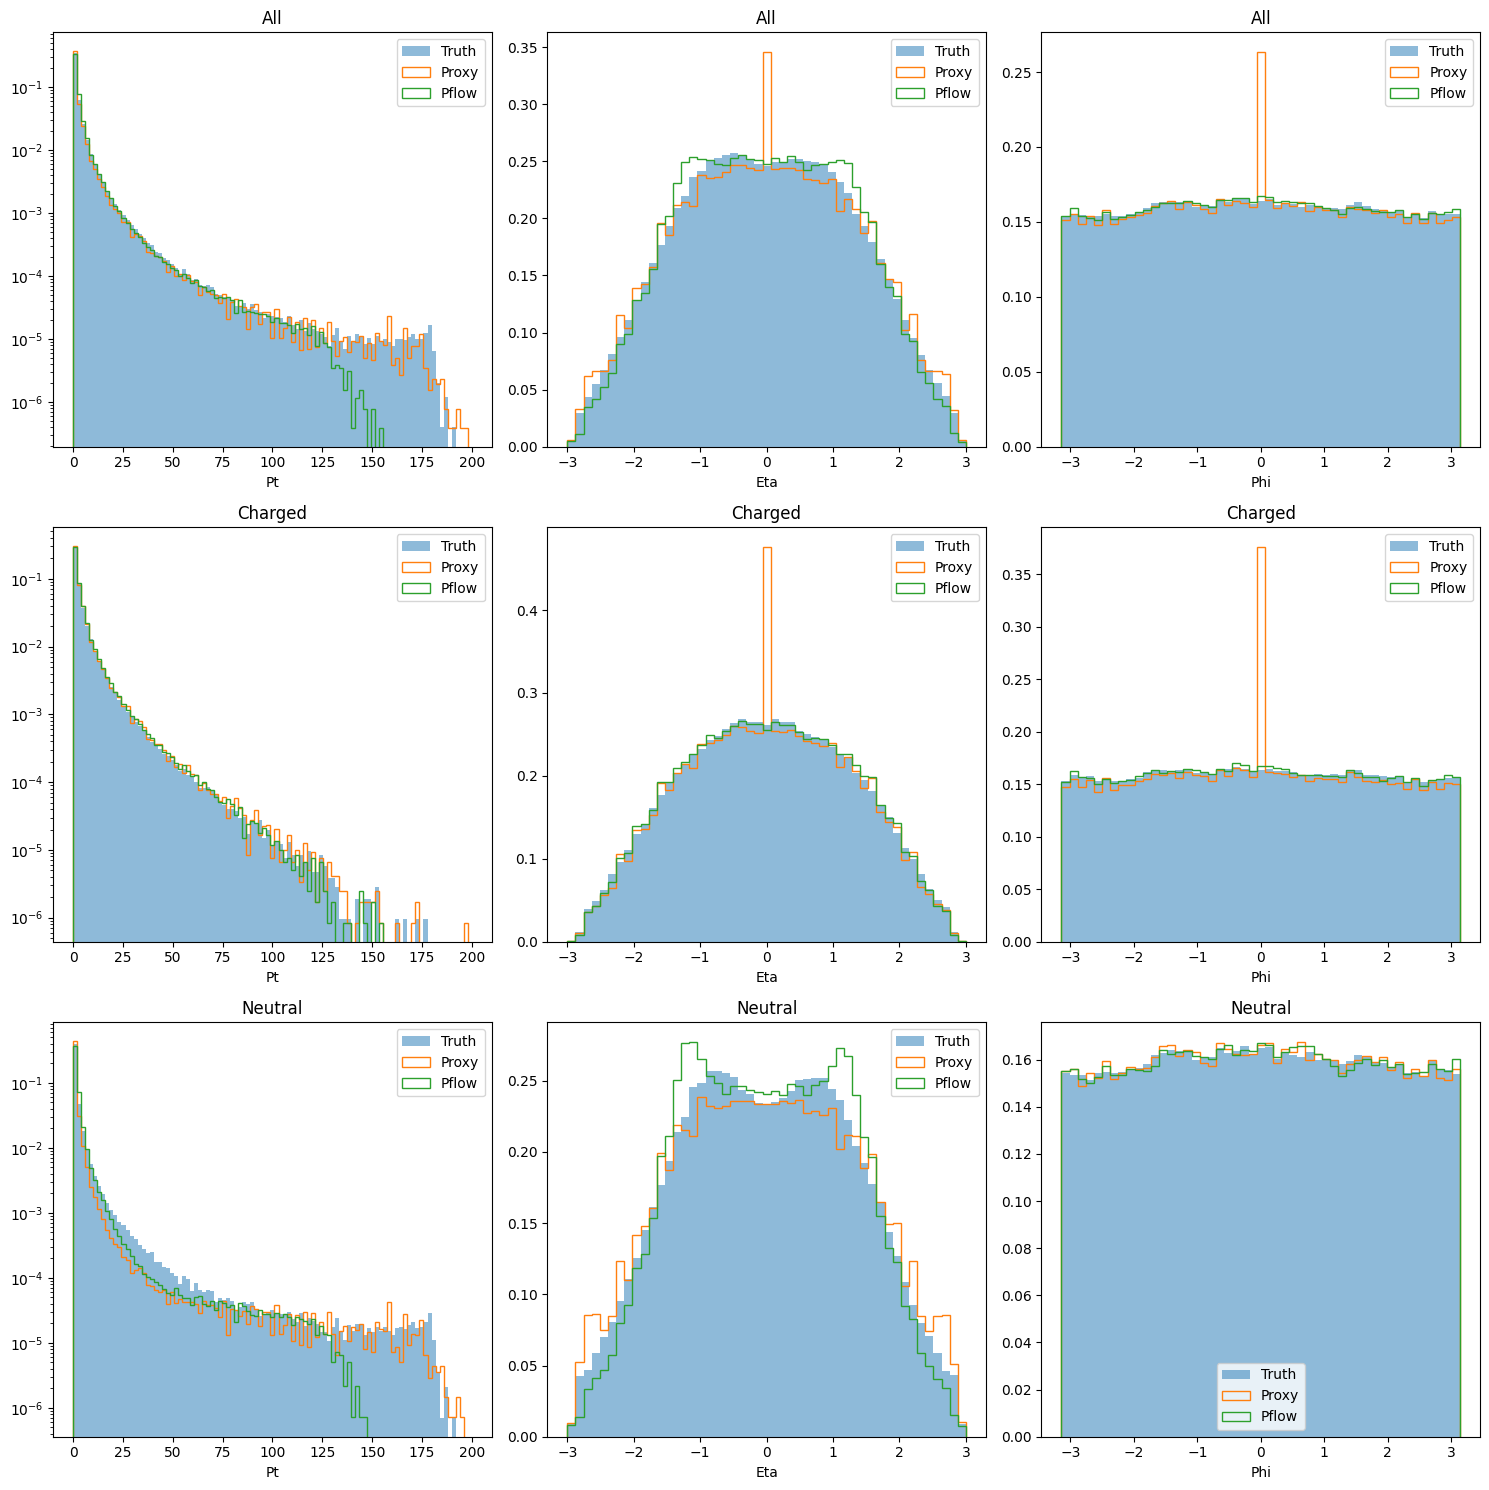

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ind_threshold = 0.65
bins = [
    np.linspace(0, 200, 100),
    np.linspace(-3, 3, 50),
    np.linspace(-np.pi, np.pi, 50),
]

truth_charge_masks = [
    (np.concatenate(truth_class) < 5) & (np.concatenate(truth_indicator) > ind_threshold),
    (np.concatenate(truth_class) < 3) & (np.concatenate(truth_indicator) > ind_threshold),
    (np.concatenate(truth_class) < 5) & (np.concatenate(truth_class) > 2) & (np.concatenate(truth_indicator) > ind_threshold),
]
pflow_charge_masks = [
    (np.concatenate(pflow_class) < 5) & (np.concatenate(pflow_indicator) > ind_threshold),
    (np.concatenate(pflow_class) < 3) & (np.concatenate(pflow_indicator) > ind_threshold),
    (np.concatenate(pflow_class) < 5) & (np.concatenate(pflow_class) > 2) & (np.concatenate(pflow_indicator) > ind_threshold),
]
scale = 1
for i in range(3):
    for j, plot_type in enumerate(["All", "Charged", "Neutral"]):
        truth_feats = np.concatenate(truth_ptetaphi)[:, i][truth_charge_masks[j]]
        pflow_feats = np.concatenate(pflow_ptetaphi)[:, i][pflow_charge_masks[j]]
        proxy_feats = np.concatenate(proxy_ptetaphi)[:, i][pflow_charge_masks[j]]
        ax[j][i].hist(
            truth_feats * scale,
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="Truth",
            density=True,
        )
        ax[j][i].hist(
            proxy_feats * scale,
            bins=bins[i],
            histtype="step",
            label="Proxy",
            density=True,
        )
        ax[j][i].hist(
            pflow_feats * scale,  # * 0.85 if (i == 0) and (j == 2) else pflow_feats * scale,
            bins=bins[i],
            histtype="step",
            label="Pflow",
            density=True,
        )
        ax[j][i].set_xlabel(["Pt", "Eta", "Phi"][i])
        if i == 0:
            ax[j][i].set_yscale("log")
        ax[j][i].set_title(plot_type)
        ax[j][i].legend()
fig.tight_layout()
plt.show()

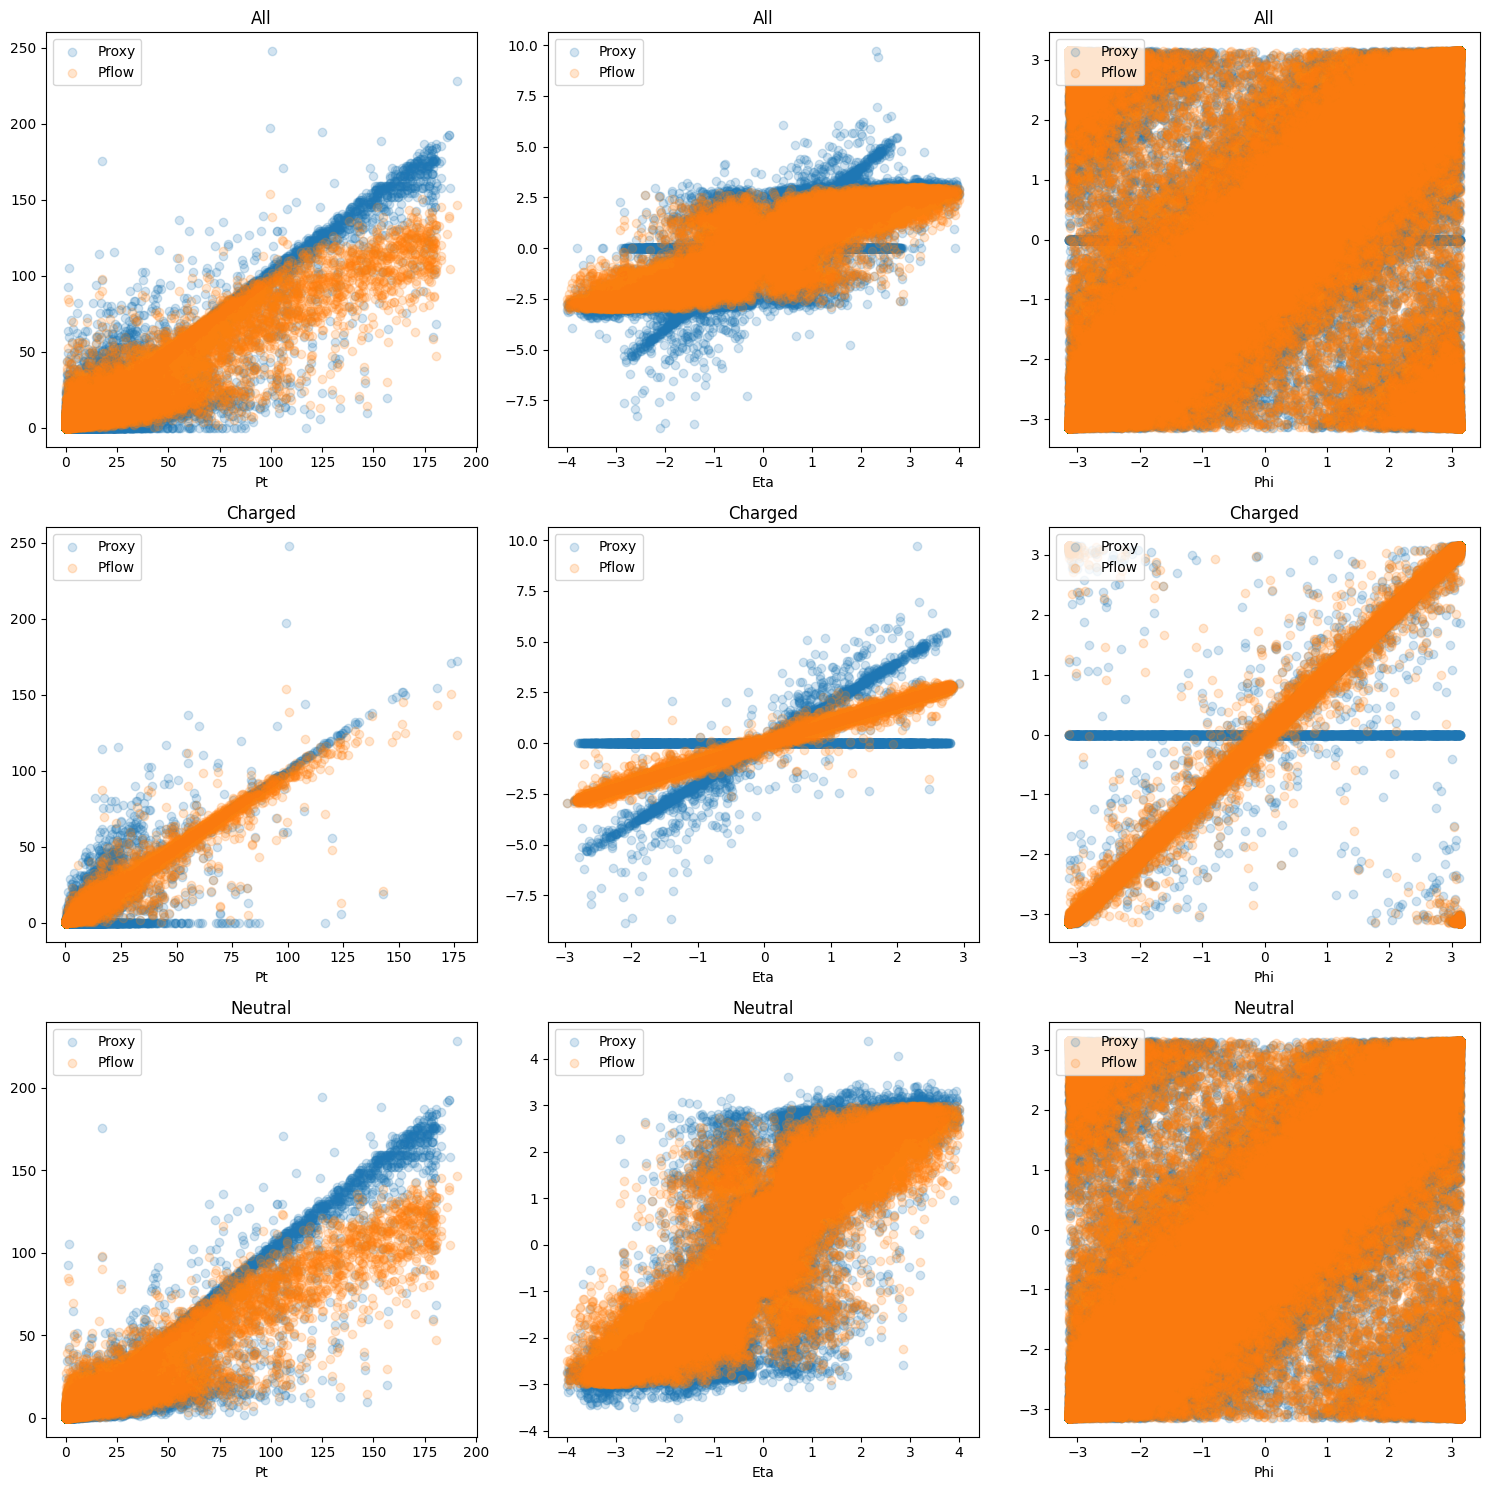

In [54]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ind_threshold = 0.65
bins = [
    np.linspace(0, 200, 100),
    np.linspace(-3, 3, 50),
    np.linspace(-np.pi, np.pi, 50),
]

charge_masks = [
    (np.concatenate(pflow_indicator) > ind_threshold) & (np.concatenate(truth_indicator) > ind_threshold),
    (np.concatenate(pflow_indicator) > ind_threshold)
    & (np.concatenate(truth_indicator) > ind_threshold)
    & (np.concatenate(pflow_class) < 3)
    & (np.concatenate(truth_class) < 3),
    (np.concatenate(pflow_indicator) > ind_threshold)
    & (np.concatenate(truth_indicator) > ind_threshold)
    & (np.concatenate(pflow_class) > 2)
    & (np.concatenate(truth_class) > 2),
]
scale = 1
for i in range(3):
    for j, plot_type in enumerate(["All", "Charged", "Neutral"]):
        truth_feats = np.concatenate(truth_ptetaphi)[:, i][charge_masks[j]]
        pflow_feats = np.concatenate(pflow_ptetaphi)[:, i][charge_masks[j]]
        proxy_feats = np.concatenate(proxy_ptetaphi)[:, i][charge_masks[j]]
        ax[j][i].scatter(
            truth_feats * scale,
            proxy_feats * scale,
            alpha=0.2,
            label="Proxy",
        )
        ax[j][i].scatter(
            truth_feats * scale,
            pflow_feats * scale,
            alpha=0.2,
            label="Pflow",
        )
        ax[j][i].set_xlabel(["Pt", "Eta", "Phi"][i])
        ax[j][i].set_title(plot_type)
        ax[j][i].legend(loc="upper left")
fig.tight_layout()
plt.show()

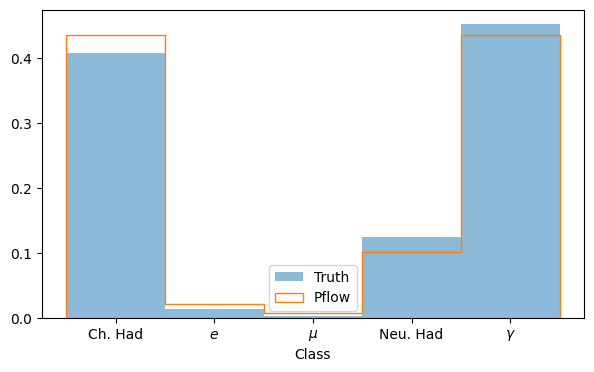

In [55]:
class_labels = ["Ch. Had", "$e$", r"$\mu$", "Neu. Had", r"$\gamma$"]
# confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(
    np.concatenate(truth_class)[np.concatenate(truth_indicator) > 0.5],
    bins=np.arange(0, 6) - 0.5,
    histtype="stepfilled",
    alpha=0.5,
    label="Truth",
    density=True,
)
ax.hist(
    np.concatenate(pflow_class)[np.concatenate(pflow_indicator) > 0.5],
    bins=np.arange(0, 6) - 0.5,
    histtype="step",
    label="Pflow",
    density=True,
)
ax.set_xlabel("Class")
ax.set_xticks(np.arange(5))
ax.set_xticklabels(class_labels)
ax.legend()
plt.show()

In [56]:
import awkward as ak
import fastjet as fj

In [57]:
def normalize_phi(phi):
    return np.atan2(np.sin(phi), np.cos(phi))

In [58]:
def get_cluster_sequence(jet_definition, four_vectors, user_indices=None):
    pj_array = []

    for i, part in enumerate(four_vectors):
        pj = fj.PseudoJet(part.px.item(), part.py.item(), part.pz.item(), part.E.item())
        if user_indices is not None:
            pj.set_user_index(user_indices[i])
        else:
            pj.set_user_index(i)
        pj_array.append(pj)

    cs = fj.ClusterSequence(pj_array, jet_definition)

    return cs

In [59]:
def get_jet_features(ptetaphi, indicator, ind_threshold=0.5):
    px = ptetaphi[:, 0][indicator > ind_threshold] * np.cos(ptetaphi[:, 2][indicator > ind_threshold])
    py = ptetaphi[:, 0][indicator > ind_threshold] * np.sin(ptetaphi[:, 2][indicator > ind_threshold])
    pz = ptetaphi[:, 0][indicator > ind_threshold] * np.sinh(ptetaphi[:, 1][indicator > ind_threshold])
    e = np.sqrt(px**2 + py**2 + pz**2)
    arr = ak.Array(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
        },
        with_name="Momentum4D",
    )
    # jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    jetdef = fj.JetDefinition(fj.kt_algorithm, 0.7)
    cs = get_cluster_sequence(jetdef, arr)
    jets = fj.sorted_by_pt(cs.inclusive_jets())
    newjets = []
    for jet in jets:
        if len(jet.constituents()) > 2 and jet.pt() > 10:
            newjets.append(jet)
    if len(newjets) == 0:
        # return np.array([0]), np.array([0]), np.array([0]), np.array([0])
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    return (
        np.array([jet.pt() for jet in newjets]),
        np.array([jet.eta() for jet in newjets]),
        np.array([normalize_phi(jet.phi()) for jet in newjets]),
        np.array([jet.m() for jet in newjets]),
        np.array([len(jet.constituents()) for jet in newjets]),
    )

In [60]:
ind_threshold = 0.5

In [61]:
to_object_array = lambda x: np.array(x, dtype=object)

In [62]:
pflow_indicator = (pflow_class < 5) & (np.abs(pflow_ptetaphi[..., 1]) < 3)
# pflow_indicator = (np.abs(pflow_ptetaphi[..., 1]) < 3) & (pflow_indicator_prob > 0.7)
truth_indicator = (truth_class < 5) & (np.abs(truth_ptetaphi[..., 1]) < 3)

In [63]:
pflow_jet_pt, pflow_jet_eta, pflow_jet_phi, pflow_jet_mass, pflow_jet_nconst = map(
    to_object_array,
    zip(
        *[
            get_jet_features(ptetaphi, indicator, ind_threshold=ind_threshold)
            for ptetaphi, indicator in zip(pflow_ptetaphi, pflow_indicator, strict=False)
        ],
        strict=False,
    ),
)
truth_jet_pt, truth_jet_eta, truth_jet_phi, truth_jet_mass, truth_jet_nconst = map(
    to_object_array,
    zip(
        *[
            get_jet_features(ptetaphi, indicator, ind_threshold=ind_threshold)
            for ptetaphi, indicator in zip(truth_ptetaphi, truth_indicator, strict=False)
        ],
        strict=False,
    ),
)
proxy_jet_pt, proxy_jet_eta, proxy_jet_phi, proxy_jet_mass, proxy_jet_nconst = map(
    to_object_array,
    zip(
        *[
            get_jet_features(ptetaphi, indicator, ind_threshold=ind_threshold)
            for ptetaphi, indicator in zip(proxy_ptetaphi, pflow_indicator, strict=False)
        ],
        strict=False,
    ),
)

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [64]:
truth_jet_pt[0]

array([50.36051826, 37.14263153])

In [65]:
def matching(input_pt, input_eta, input_phi, truth_pt, truth_eta, truth_phi, dr_cut=0.4):
    def mse(a, b):
        return (a - b) ** 2

    input_indices = []
    truth_indices = []
    hung_cost = np.zeros(len(input_phi))

    for i in tqdm(range(len(input_phi)), desc="matching"):
        mask = input_pt[i] > 0
        tr_mask = truth_pt[i] > 0
        input_eta_i = input_eta[i][mask]
        input_phi_i = input_phi[i][mask]

        truth_eta_i = truth_eta[i][tr_mask]
        truth_phi_i = truth_phi[i][tr_mask]

        truth_eta_i = np.tile(np.expand_dims(truth_eta_i, axis=1), (1, len(input_eta_i)))  # row content same
        input_eta_i = np.tile(np.expand_dims(input_eta_i, axis=0), (len(truth_eta_i), 1))  # column content same

        truth_phi_i = np.tile(np.expand_dims(truth_phi_i, axis=1), (1, len(input_phi_i)))  # row content same
        input_phi_i = np.tile(np.expand_dims(input_phi_i, axis=0), (len(truth_phi_i), 1))  # column content same

        loss_phi = mse(truth_phi_i, input_phi_i)
        loss_eta = mse(truth_eta_i, input_eta_i)

        loss = np.sqrt(loss_eta + loss_phi)
        loss_hung = loss.copy()

        # loss[loss == np.inf] = 1000
        # loss[loss == np.nan] = 1000
        # truth_ix, input_ix = linear_sum_assignment(loss)

        # indices = input_ix.shape[0] * truth_ix + input_ix

        # loss_extract = np.take_along_axis(loss_hung.flatten(), indices, axis=0)

        # hung_cost[i] = loss_extract.mean()

        dr = np.sqrt(loss_eta + loss_phi)
        loss[dr > dr_cut] = 1e3

        loss[loss == np.inf] = 1000
        loss[loss == np.nan] = 1000
        truth_ix, input_ix = linear_sum_assignment(loss)

        # Create boolean mask for dr < 0.6
        mask = dr <= dr_cut

        # Find all pairs (i, j) where dr < 0.6
        filtered_pairs = np.argwhere(mask)

        # Convert truth_ix and input_ix into sets for fast lookups
        truth_input_pairs = set(zip(truth_ix, input_ix, strict=False))

        # Select new pairs where (i, j) are in the filtered_pairs and truth_input_pairs
        new_pairs = np.array([pair for pair in filtered_pairs if tuple(pair) in truth_input_pairs])

        # Split new pairs into new_truth_ix and new_input_ix
        if len(new_pairs) == 0:
            new_truth_ix = []
            new_input_ix = []
        else:
            new_truth_ix, new_input_ix = new_pairs.T

        input_ix = np.array(new_input_ix)
        truth_ix = np.array(new_truth_ix)

        if len(new_pairs) == 0:
            hung_cost[i] = 1000
            # print(i)
        else:
            indices = input_ix.shape[0] * truth_ix + input_ix
            loss_extract = np.take_along_axis(loss_hung.flatten(), indices, axis=0)
            hung_cost[i] = loss_extract.mean()
        input_indices.append(input_ix)
        truth_indices.append(truth_ix)

    print("Matching done!")

    return (
        np.array(truth_indices, dtype=object),
        np.array(input_indices, dtype=object),
        hung_cost,
    )

In [66]:
tr_pf_indices, pf_indices, hung_cost = matching(
    pflow_jet_pt,
    pflow_jet_eta,
    pflow_jet_phi,
    truth_jet_pt,
    truth_jet_eta,
    truth_jet_phi,
)
if not np.allclose(proxy_data[..., 0], 0):
    tr_pr_indices, pr_indices, hung_cost = matching(
        proxy_jet_pt,
        proxy_jet_eta,
        proxy_jet_phi,
        truth_jet_pt,
        truth_jet_eta,
        truth_jet_phi,
    )

matching: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:02<00:00, 8551.34it/s]


Matching done!


matching: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:02<00:00, 8802.92it/s]

Matching done!


In [67]:
def get_residuals(
    truth_indices,
    pred_indices,
    truth_pt,
    truth_eta,
    truth_phi,
    pred_pt,
    pred_eta,
    pred_phi,
):
    res_pt = []
    res_eta = []
    res_phi = []

    for i in range(len(truth_indices)):
        if len(truth_indices[i]) == 0 or len(pred_indices[i]) == 0:
            continue
        res_pt.append((pred_pt[i][pred_indices[i]] - truth_pt[i][truth_indices[i]]) / truth_pt[i][truth_indices[i]])
        res_eta.append(pred_eta[i][pred_indices[i]] - truth_eta[i][truth_indices[i]])
        res_phi.append(pred_phi[i][pred_indices[i]] - truth_phi[i][truth_indices[i]])

    return np.concatenate(res_pt), np.concatenate(res_eta), np.concatenate(res_phi)

In [68]:
n_pflow_jets = np.array([len(el) for el in pflow_jet_pt])
n_truth_jets = np.array([len(el) for el in truth_jet_pt])
n_proxy_jets = np.array([len(el) for el in proxy_jet_pt])
# n_hgpf_jets = np.array([len(el) for el in hgpf_jet_pt])
if np.allclose(proxy_data[..., 0], 0):
    mask = (n_pflow_jets > 0) & (n_truth_jets > 0)
else:
    mask = (n_pflow_jets > 0) & (n_truth_jets > 0) & (n_proxy_jets > 0)  # & (n_hgpf_jets > 0)

In [69]:
pflow_tr_res_pt, pflow_tr_res_eta, pflow_tr_res_phi = get_residuals(
    tr_pf_indices[mask],
    pf_indices[mask],
    truth_jet_pt[mask],
    truth_jet_eta[mask],
    truth_jet_phi[mask],
    pflow_jet_pt[mask],
    pflow_jet_eta[mask],
    pflow_jet_phi[mask],
)
if not np.allclose(proxy_data[..., 0], 0):
    proxy_tr_res_pt, proxy_tr_res_eta, proxy_tr_res_phi = get_residuals(
        tr_pr_indices[mask],
        pr_indices[mask],
        truth_jet_pt[mask],
        truth_jet_eta[mask],
        truth_jet_phi[mask],
        proxy_jet_pt[mask],
        proxy_jet_eta[mask],
        proxy_jet_phi[mask],
    )

In [70]:
def get_jet_nconst(jet_nconst):
    nconst = []
    for el in jet_nconst:
        if len(el) == 0:
            continue
        nconst.append(el[0])
    return np.array(nconst)

In [71]:
from scipy.stats import iqr

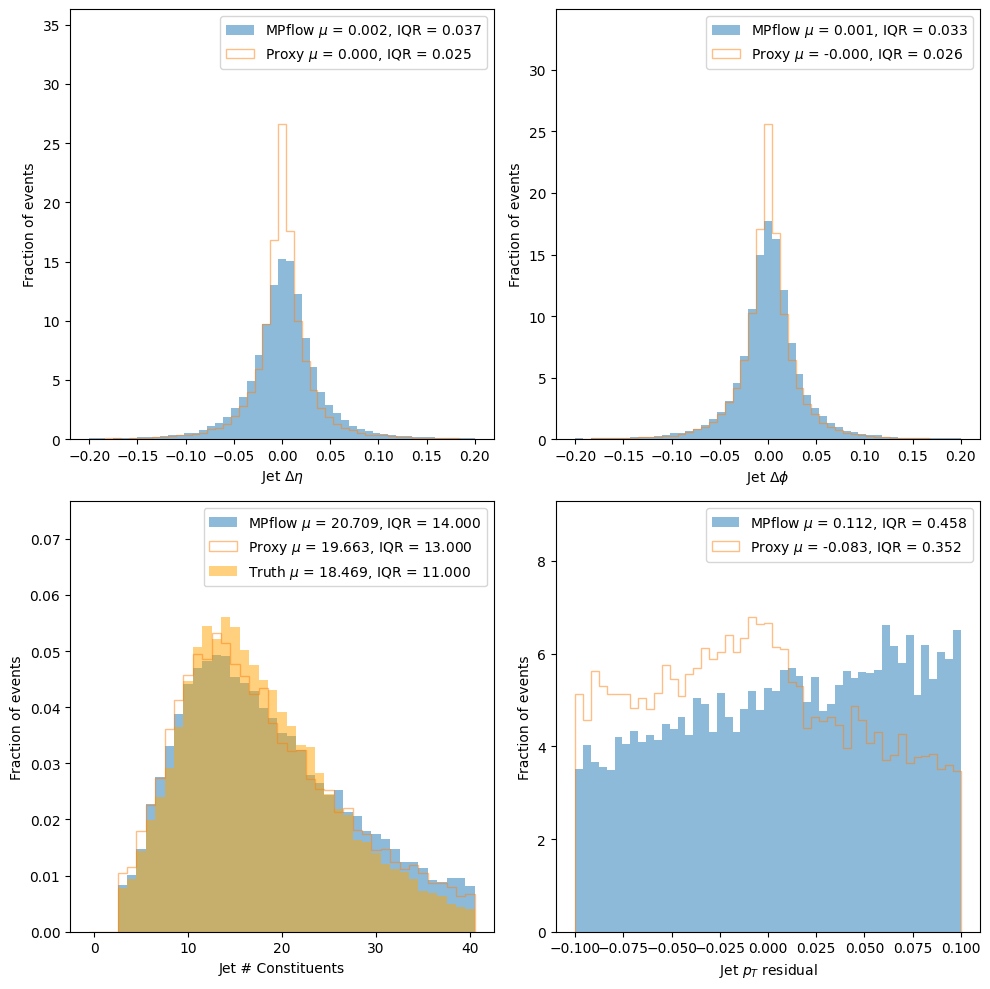

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

bins = [
    np.linspace(-0.2, 0.2, 50),
    np.linspace(-0.2, 0.2, 50),
    np.linspace(-0.5, 40.5, 42),
    np.linspace(-0.1, 0.1, 50),
]
data_arr = [
    pflow_tr_res_eta,
    pflow_tr_res_phi,
    get_jet_nconst(pflow_jet_nconst),
    pflow_tr_res_pt,
]
if not np.allclose(proxy_data[..., 0], 0):
    proxy_data_arr = [
        proxy_tr_res_eta,
        proxy_tr_res_phi,
        get_jet_nconst(proxy_jet_nconst),
        proxy_tr_res_pt,
    ]

for i in range(4):
    ax[i // 2, i % 2].hist(
        data_arr[i],
        bins=bins[i],
        histtype="stepfilled",
        alpha=0.5,
        density=True,
        label=rf"MPflow $\mu$ = {np.mean(data_arr[i]):.3f}, IQR = {iqr(data_arr[i]):.3f}",
    )
    if not np.allclose(proxy_data[..., 0], 0):
        ax[i // 2, i % 2].hist(
            proxy_data_arr[i],
            bins=bins[i],
            histtype="step",
            alpha=0.5,
            density=True,
            label=rf"Proxy $\mu$ = {np.mean(proxy_data_arr[i]):.3f}, IQR = {iqr(proxy_data_arr[i]):.3f}",
        )

    ax[i // 2, i % 2].set_xlabel(
        [
            r"Jet $\Delta\eta$",
            r"Jet $\Delta\phi$",
            "Jet # Constituents",
            "Jet $p_T$ residual",
        ][i]
    )
    if i == 2:
        truth_nconst = get_jet_nconst(truth_jet_nconst)
        ax[1, 0].hist(
            truth_nconst,
            bins=bins[2],
            histtype="stepfilled",
            alpha=0.5,
            label=rf"Truth $\mu$ = {np.mean(truth_nconst):.3f}, IQR = {iqr(truth_nconst):.3f}",
            color="orange",
            density=True,
        )
    ax[i // 2, i % 2].set_ylabel("Fraction of events")
    ymin, ymax = ax[i // 2, i % 2].get_ylim()
    ax[i // 2, i % 2].set_ylim(ymin, ymax * 1.3)
    ax[i // 2, i % 2].legend(loc="upper right")
fig.tight_layout()

In [73]:
def plot_pt(ax, pt, eta, phi, shift, color="k"):
    center_phi, center_eta = normalize_phi(phi), eta
    ax.text(
        center_phi + shift[0],
        center_eta + shift[1],
        f"{pt:.2f} GeV",
        ha="center",
        va="center",
        color=color,
    )

In [74]:
def plot_event(
    pflow_ptetaphi,
    pflow_class,
    pflow_ind,
    truth_ptetaphi,
    truth_class,
    truth_ind,
    pflow_jet_pt,
    pflow_jet_eta,
    pflow_jet_phi,
    truth_jet_pt,
    truth_jet_eta,
    truth_jet_phi,
    idx,
    ind_threshold,
    proxy_ptetaphi=None,
):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    pf_mask = pflow_ind[idx] > ind_threshold
    truth_mask = truth_ind[idx] > ind_threshold
    classes = ["Ch H", "El", "Mu", "Neut H", "Phot"]
    colors = ["red", "blue", "green", "orange", "purple"]
    for i, c in enumerate(classes):
        pf_class_mask = pflow_class[idx] == i
        tr_class_mask = truth_class[idx] == i
        ax.scatter(
            normalize_phi(pflow_ptetaphi[idx][:, 2][pf_mask & pf_class_mask]),
            pflow_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
            # alpha=0.5,
            s=pflow_ptetaphi[idx][:, 0][pf_mask & pf_class_mask] * 10,
            marker="x",
            color=colors[i],
        )
        ax.scatter(
            normalize_phi(truth_ptetaphi[idx][:, 2][truth_mask & tr_class_mask]),
            truth_ptetaphi[idx][:, 1][truth_mask & tr_class_mask],
            alpha=0.5,
            s=truth_ptetaphi[idx][:, 0][truth_mask & tr_class_mask] * 10,
            color=colors[i],
        )
        if proxy_ptetaphi is not None:
            ax.scatter(
                normalize_phi(proxy_ptetaphi[idx][:, 2][pf_mask & pf_class_mask]),
                proxy_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
                # alpha=0.5,
                s=proxy_ptetaphi[idx][:, 0][pf_mask & pf_class_mask] * 10,
                marker="s",
                facecolors="none",
                color=colors[i],
            )

    # draw circle
    for jet_idx in range(len(truth_jet_phi[idx])):
        circle = plt.Circle(
            (truth_jet_phi[idx][jet_idx], truth_jet_eta[idx][jet_idx]),
            0.4,
            color="k",
            fill=False,
        )
        ax.add_artist(circle)
    for jet_idx in range(len(pflow_jet_phi[idx])):
        circle = plt.Circle(
            (pflow_jet_phi[idx][jet_idx], pflow_jet_eta[idx][jet_idx]),
            0.4,
            color="r",
            fill=False,
        )
        ax.add_artist(circle)

    for jet_idx in range(len(pflow_jet_phi[idx])):
        plot_pt(
            ax,
            pflow_jet_pt[idx][jet_idx],
            pflow_jet_eta[idx][jet_idx],
            pflow_jet_phi[idx][jet_idx],
            shift=(-0.34, -0.4),
            color="r",
        )
    for jet_idx in range(len(truth_jet_phi[idx])):
        plot_pt(
            ax,
            truth_jet_pt[idx][jet_idx],
            truth_jet_eta[idx][jet_idx],
            truth_jet_phi[idx][jet_idx],
            shift=(0.34, 0.46),
            color="k",
        )

    legend_handles = [plt.Line2D([0], [0], marker="o", color=colors[i], label=c) for i, c in enumerate(classes)]
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-3, 3)
    ax.legend(handles=legend_handles)
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    # ax.legend()
    plt.show()

In [75]:
def plot_event_splitted(
    pflow_ptetaphi,
    pflow_class,
    pflow_ind,
    truth_ptetaphi,
    truth_class,
    truth_ind,
    pflow_jet_pt=None,
    pflow_jet_eta=None,
    pflow_jet_phi=None,
    truth_jet_pt=None,
    truth_jet_eta=None,
    truth_jet_phi=None,
    idx=0,
    ind_threshold=0.5,
    proxy_ptetaphi=None,
):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
    pf_mask = pflow_ind[idx] > ind_threshold
    tr_mask = truth_ind[idx] > ind_threshold

    classes = ["Ch H", "El", "Mu", "Neut H", "Phot"]
    colors = ["red", "blue", "green", "orange", "purple"]
    for i, c in enumerate(classes):
        pf_class_mask = pflow_class[idx] == i
        tr_class_mask = truth_class[idx] == i
        ax[0].scatter(
            normalize_phi(truth_ptetaphi[idx][:, 2][tr_mask & tr_class_mask]),
            truth_ptetaphi[idx][:, 1][tr_mask & tr_class_mask],
            alpha=0.3,
            color=colors[i],
        )
        ax[0].scatter(
            normalize_phi(pflow_ptetaphi[idx][:, 2][pf_mask & pf_class_mask]),
            pflow_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
            # alpha=0.5,
            marker="x",
            color=colors[i],
        )
        ax[1].scatter(
            truth_ptetaphi[idx][:, 0][tr_mask & tr_class_mask],
            truth_ptetaphi[idx][:, 1][tr_mask & tr_class_mask],
            alpha=0.3,
            color=colors[i],
        )
        ax[1].scatter(
            pflow_ptetaphi[idx][:, 0][pf_mask & pf_class_mask],
            pflow_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
            # alpha=0.5,
            marker="x",
            color=colors[i],
        )
        if proxy_ptetaphi is not None:
            ax[0].scatter(
                normalize_phi(proxy_ptetaphi[idx][:, 2][pf_mask & pf_class_mask]),
                proxy_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
                # alpha=0.5,
                marker="s",
                facecolors="none",
                color=colors[i],
            )
            ax[1].scatter(
                proxy_ptetaphi[idx][:, 0][pf_mask & pf_class_mask],
                proxy_ptetaphi[idx][:, 1][pf_mask & pf_class_mask],
                # alpha=0.5,
                marker="s",
                facecolors="none",
                color=colors[i],
            )
    if truth_jet_phi is not None:
        for jet_idx in range(len(truth_jet_phi[idx])):
            circle = plt.Circle(
                (truth_jet_phi[idx][jet_idx], truth_jet_eta[idx][jet_idx]),
                0.4,
                color="k",
                fill=False,
            )
            ax[0].add_artist(circle)
        for jet_idx in range(len(truth_jet_phi[idx])):
            plot_pt(
                ax[0],
                truth_jet_pt[idx][jet_idx],
                truth_jet_eta[idx][jet_idx],
                truth_jet_phi[idx][jet_idx],
                shift=(0.34, 0.46),
                color="k",
            )

    if pflow_jet_phi is not None:
        for jet_idx in range(len(pflow_jet_phi[idx])):
            circle = plt.Circle(
                (pflow_jet_phi[idx][jet_idx], pflow_jet_eta[idx][jet_idx]),
                0.4,
                color="r",
                fill=False,
            )
            ax[0].add_artist(circle)

        for jet_idx in range(len(pflow_jet_phi[idx])):
            plot_pt(
                ax[0],
                pflow_jet_pt[idx][jet_idx],
                pflow_jet_eta[idx][jet_idx],
                pflow_jet_phi[idx][jet_idx],
                shift=(-0.34, -0.4),
                color="r",
            )
    legend_handles = [plt.Line2D([0], [0], marker="o", color=colors[i], label=c) for i, c in enumerate(classes)]
    ax[0].legend(handles=legend_handles)
    ax[0].set_xlabel("Phi")
    ax[0].set_ylabel("Eta")
    ax[1].set_xlabel("Pt")
    ax[1].set_ylabel("Eta")
    ax[1].legend()

    ax[0].set_xlim(-np.pi, np.pi)
    ax[0].set_ylim(-3, 3)

    ax[1].set_ylim(-3, 3)
    fig.tight_layout()
    plt.show()

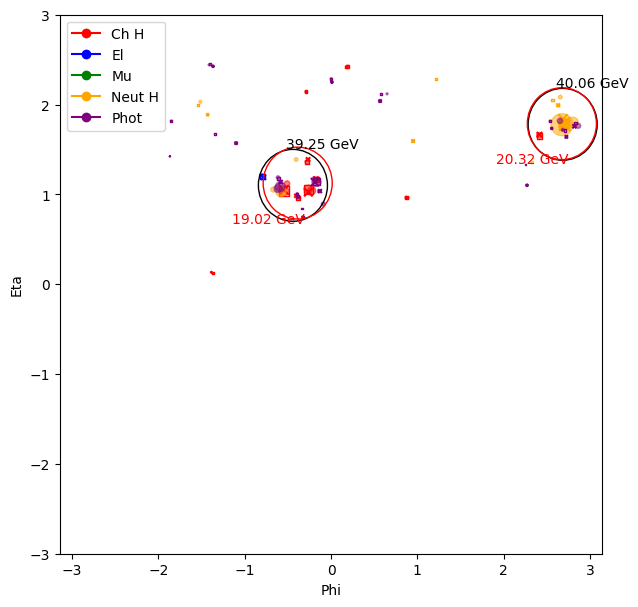

In [76]:
plot_event(
    pflow_ptetaphi,
    pflow_class,
    pflow_indicator,
    truth_ptetaphi,
    truth_class,
    truth_indicator,
    pflow_jet_pt,
    pflow_jet_eta,
    pflow_jet_phi,
    truth_jet_pt,
    truth_jet_eta,
    truth_jet_phi,
    idx=1,
    ind_threshold=0.5,
    proxy_ptetaphi=proxy_ptetaphi,
)

/tmp/ipykernel_37631/3685252073.py:114: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


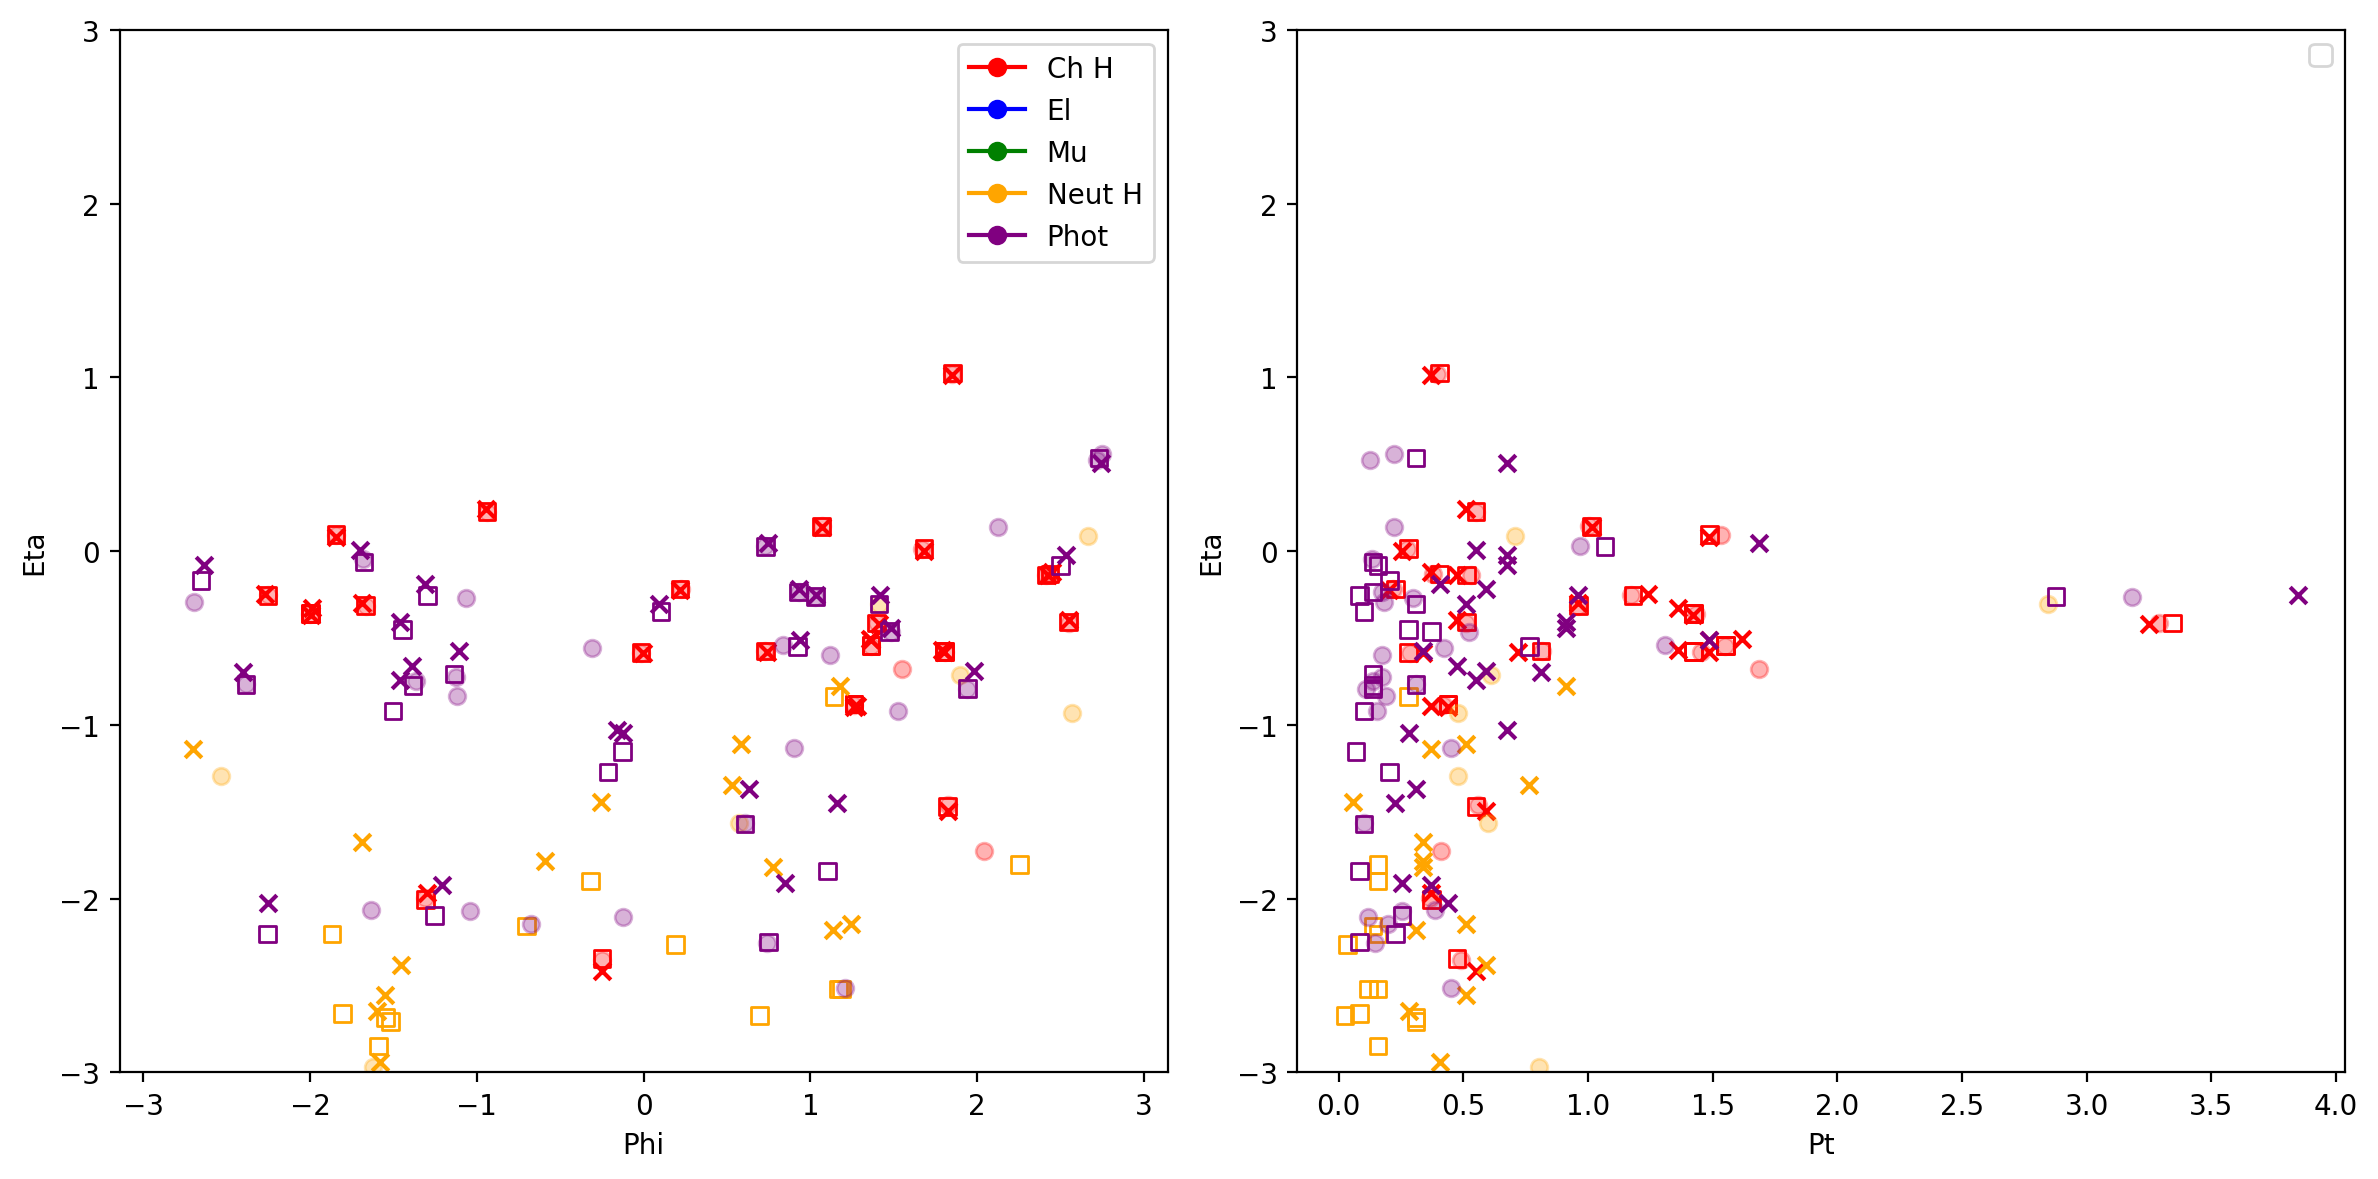

In [77]:
plot_event_splitted(
    pflow_ptetaphi,
    pflow_class,
    pflow_indicator,
    truth_ptetaphi,
    truth_class,
    truth_indicator,
    # pflow_jet_pt,
    # pflow_jet_eta,
    # pflow_jet_phi,
    # truth_jet_pt,
    # truth_jet_eta,
    # truth_jet_phi,
    idx=2,
    ind_threshold=0.5,
    proxy_ptetaphi=proxy_ptetaphi,
)

In [78]:
def plot_incidences(pflow_inc, truth_inc, idx, pflow_ind=None, truth_ind=None, ind_threshold=0.5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if pflow_ind is not None:
        pflow_inc = pflow_inc[idx][pflow_ind[idx] > ind_threshold]
    else:
        pflow_inc = pflow_inc[idx]
    if truth_ind is not None:
        truth_inc = truth_inc[idx][truth_ind[idx] > ind_threshold]
    else:
        truth_inc = truth_inc[idx]
    ax[0].imshow(pflow_inc[:, :100], aspect="auto", vmin=0, vmax=1)
    ax[0].set_title("Pflow")
    ax[1].imshow(truth_inc[:, :100], aspect="auto", vmin=0, vmax=1)
    ax[1].set_title("Truth")
    plt.show()

In [79]:
def plot_incidence_diff(pflow_inc, truth_inc, idx, pflow_ind=None, truth_ind=None, ind_threshold=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if pflow_ind is not None:
        pflow_inc = pflow_inc[idx][pflow_ind[idx] > ind_threshold]
    else:
        pflow_inc = pflow_inc[idx]
    if truth_ind is not None:
        truth_inc = truth_inc[idx][truth_ind[idx] > ind_threshold]
    else:
        truth_inc = truth_inc[idx]
    ax.imshow(
        pflow_inc[:, :100] - truth_inc[:, :100],
        aspect="auto",
        vmin=-1,
        vmax=1,
        cmap="coolwarm",
    )
    plt.show()

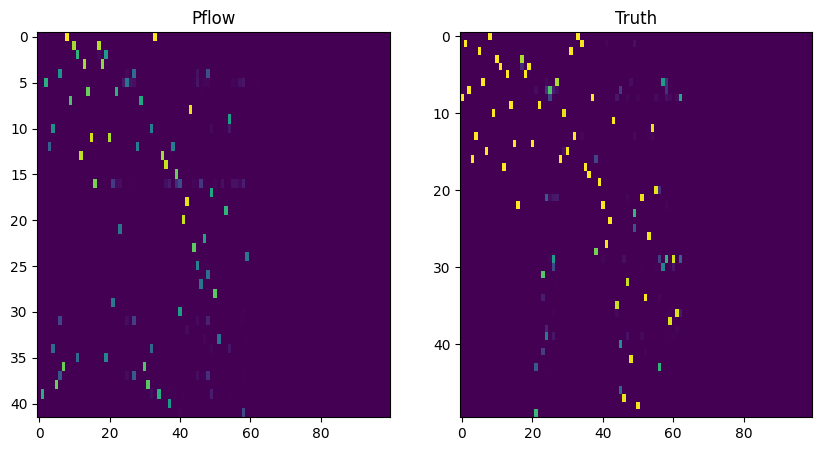

In [80]:
plot_incidences(
    pflow_incidence,
    truth_incidence,
    0,
    pflow_ind=pflow_indicator,
    truth_ind=truth_indicator,
    ind_threshold=0.5,
)

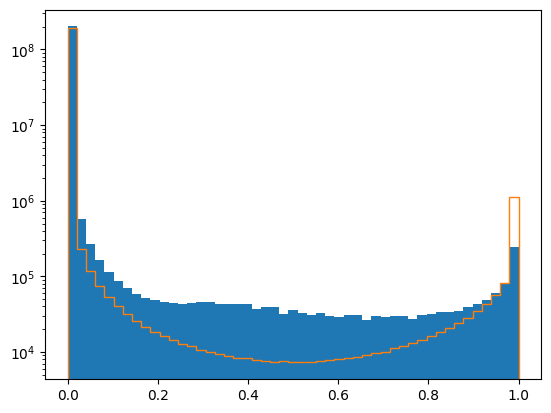

In [81]:
plt.hist(
    np.concatenate(pflow_incidence)[np.concatenate(pflow_indicator) > 0.5].flatten(),
    bins=np.linspace(0, 1, 50),
)
plt.hist(
    np.concatenate(truth_incidence)[np.concatenate(truth_indicator) > 0.5].flatten(),
    bins=np.linspace(0, 1, 50),
    histtype="step",
)
plt.yscale("log")

In [82]:
def load_file_simple(filepath, return_dict=False):
    with h5py.File(filepath, "r") as f:
        truth_incidence_bool = f["object_masks"]["truth_masks"][:]
        pflow_incidence_bool = f["object_masks"]["mask_logits"][:]

        if "incidence" in f:
            truth_incidence = f["incidence"]["truth_incidence"][:]
            pflow_incidence = f["incidence"]["pred_incidence"][:]
        else:
            truth_incidence = np.zeros_like(truth_incidence_bool)
            pflow_incidence = np.zeros_like(pflow_incidence_bool)

        pflow_incidence = pflow_incidence

        pflow_incidence_bool = pflow_incidence_bool

        truth_class = f["object_class"]["object_class"][:]
        if "Bin" in filepath:
            pflow_class_probs_raw = np.stack([f["object_class"][f"class_probs_{i}"][:] for i in range(2)], axis=-1)
            pflow_class_probs = pflow_class_probs_raw
            pflow_class = np.argmax(pflow_class_probs, axis=-1)
        else:
            pflow_class_probs_raw = np.stack([f["object_class"][f"class_probs_{i}"][:] for i in range(6)], axis=-1)
            pflow_class_probs = pflow_class_probs_raw
            pflow_class = np.argmax(pflow_class_probs, axis=-1)

        truth_data = np.stack([f["regression"][f"truth_{el}"][:] for el in ["e", "pt", "eta", "sinphi", "cosphi"]], axis=-1)
        pflow_data = np.stack([f["regression"][f"pred_{el}"][:] for el in ["e", "pt", "eta", "sinphi", "cosphi"]], axis=-1)
        proxy_data = np.stack([f["regression"][f"proxy_{el}"][:] for el in ["e", "pt", "eta", "sinphi", "cosphi"]], axis=-1)

        pflow_ptetaphi = np.stack(
            [
                ds.var_transform["pt"].inverse_transform(torch.from_numpy(pflow_data[..., 1])).numpy(),
                ds.var_transform["eta"].inverse_transform(torch.from_numpy(pflow_data[..., 2])).numpy(),
                np.arctan2(pflow_data[..., 3], pflow_data[..., 4]),
            ],
            axis=-1,
        )
        truth_ptetaphi = np.stack(
            [
                ds.var_transform["pt"].inverse_transform(torch.from_numpy(truth_data[..., 1])).numpy(),
                ds.var_transform["eta"].inverse_transform(torch.from_numpy(truth_data[..., 2])).numpy(),
                np.arctan2(truth_data[..., 3], truth_data[..., 4]),
            ],
            axis=-1,
        )
        proxy_ptetaphi = np.stack(
            [
                ds.var_transform["pt"].inverse_transform(torch.from_numpy(proxy_data[..., 1])).numpy(),
                ds.var_transform["eta"].inverse_transform(torch.from_numpy(proxy_data[..., 2])).numpy(),
                np.arctan2(proxy_data[..., 3], proxy_data[..., 4]),
            ],
            axis=-1,
        )

        if "Bin" in filepath:
            pflow_indicator = pflow_class < 1
            truth_indicator = truth_class < 1
        else:
            pflow_indicator = pflow_class < 5
            # pflow_indicator = truth_class < 5
            truth_indicator = truth_class < 5

        neutral_mask = (pflow_class < 5) & (pflow_class > 2)
        pflow_ptetaphi[neutral_mask][..., 0] = ds.var_transform["e"].inverse_transform(
            torch.from_numpy(pflow_data[neutral_mask][..., 0])
        ).numpy() / np.cosh(pflow_ptetaphi[neutral_mask][..., 1])
        proxy_ptetaphi[neutral_mask][..., 0] = ds.var_transform["e"].inverse_transform(
            torch.from_numpy(proxy_data[neutral_mask][..., 0])
        ).numpy() / np.cosh(proxy_ptetaphi[neutral_mask][..., 1])
        if return_dict:
            return {
                "pflow_incidence": pflow_incidence,
                "truth_incidence": truth_incidence,
                "pflow_class": pflow_class,
                "truth_class": truth_class,
                "pflow_class_probs": pflow_class_probs,
                "truth_class_probs": pflow_class_probs_raw,
                "pflow_data": pflow_data,
                "truth_data": truth_data,
                "proxy_data": proxy_data,
                "pflow_ptetaphi": pflow_ptetaphi,
                "truth_ptetaphi": truth_ptetaphi,
                "proxy_ptetaphi": proxy_ptetaphi,
                "pflow_indicator": pflow_indicator,
                "truth_indicator": truth_indicator,
            }

        return (
            pflow_incidence,
            truth_incidence,
            pflow_incidence_bool,
            truth_incidence_bool,
            pflow_class,
            truth_class,
            pflow_class_probs,
            pflow_class_probs_raw,
            pflow_data,
            truth_data,
            proxy_data,
            pflow_ptetaphi,
            truth_ptetaphi,
            proxy_ptetaphi,
            pflow_indicator,
            truth_indicator,
        )

In [ ]:
(
    pflow_incidence,
    truth_incidence,
    pflow_incidence_bool,
    truth_incidence_bool,
    pflow_class,
    truth_class,
    pflow_class_probs,
    pflow_class_probs_raw,
    pflow_data,
    truth_data,
    proxy_data,
    pflow_ptetaphi,
    truth_ptetaphi,
    proxy_ptetaphi,
    pflow_indicator,
    truth_indicator,
) = load_file_simple(eval_filepath)

In [ ]:
event_number = np.arange(len(pflow_ptetaphi))

In [ ]:
pflow_indicator = (pflow_class < 5) & (np.abs(pflow_ptetaphi[..., 1]) < 3)

In [ ]:
with uproot.recreate("/home/syw24/ftag/hepattn/logs/CLIC_Pflow_Full_20250620-T014846/ckpts/epoch=097-val_loss=0.60140__test.root") as f:
    f["event_tree"] = {
        "hgpflow": {
            "pt": ak.Array(pflow_ptetaphi[..., 0]),
            "eta": ak.Array(pflow_ptetaphi[..., 1]),
            "phi": ak.Array(pflow_ptetaphi[..., 2]),
            "class": ak.Array(pflow_class),
        },
        "proxy": {
            "pt": ak.Array(proxy_ptetaphi[..., 0]),
            "eta": ak.Array(proxy_ptetaphi[..., 1]),
            "phi": ak.Array(proxy_ptetaphi[..., 2]),
        },
        "pred_ind": ak.Array(pflow_indicator),
        "event_number": ak.Array(ds.event_number),
    }

In [ ]:
proxy_ptetaphi[0, 0]

In [ ]:
pflow_ptetaphi[0, 0]